# Covid-19 - Wealth Distribution

## Selected Euro Area Countries for Analysis

| Country       | Wealth Distribution Profile                                                                 | Key Features                                                                                     |
|---------------|---------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| Germany       | High wealth inequality, with a large gap between the richest and poorest households.         | Top 10% hold over 50% of net wealth; strong regional disparities (east vs. west).                |
| France        | Moderate inequality, but with significant wealth concentration at the top.                  | Top 10% hold around 45-50% of net wealth; high homeownership rates.                               |
| Slovenia      | Relatively lower inequality compared to Germany and France.                                 | More balanced distribution; top 10% hold closer to 35-40% of net wealth; smaller wealth gaps.   |

**Why these countries?**
- **Germany** is often cited for its high wealth inequality, influenced by historical, economic, and regional factors.
- **France** shows a more moderate but still pronounced concentration of wealth, with a strong middle class and high homeownership.
- **Slovenia** represents a case of lower inequality within the euro area, making it an interesting contrast for comparative analysis.

---
### Notebook Structure (Refactored)
1. Data loading & filtering
2. Reusable helpers (metric dictionaries, plotting, modeling, evaluation)
3. Exploratory wealth panels (per country)
4. Predictive modeling (2016–2019 → 2020–2025)
5. Prediction vs Actual comparisons
6. Error metrics & model diagnostics
7. COVID-19 data integration & merging
8. Joint COVID–wealth visualization & correlations
9. Summary insights & caveats

> The following cells now rely on helper functions to reduce duplication and improve clarity.

In [1]:
# Imports & Data Preparation (Consolidated)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Global plotting style
plt.style.use('seaborn-v0_8')

# Wealth metric dictionary
WEALTH_METRICS = {
    'DE': {
        'total_assets': 'Adjusted total assets of households (DWA.Q.DE.S14.A.LE.F_NNA._Z.EUR.S.N)',
        'median_wealth': 'Net wealth of households, median (DWA.Q.DE.S14.N.LE.NWA._Z.EUR_MD.S.N)',
        'mean_wealth': 'Net wealth of households, mean (DWA.Q.DE.S14.N.LE.NWA._Z.EUR_MN.S.N)',
        'net_wealth': 'Adjusted wealth (net) of households (DWA.Q.DE.S14.N.LE.NWA._Z.EUR.S.N)',
        'gini': 'Gini coefficient of households (DWA.Q.DE.S14._Z._Z.NWA._Z.GI.S.N)'
    },
    'FR': {
        'total_assets': 'Adjusted total assets of households (DWA.Q.FR.S14.A.LE.F_NNA._Z.EUR.S.N)',
        'median_wealth': 'Net wealth of households, median (DWA.Q.FR.S14.N.LE.NWA._Z.EUR_MD.S.N)',
        'mean_wealth': 'Net wealth of households, mean (DWA.Q.FR.S14.N.LE.NWA._Z.EUR_MN.S.N)',
        'net_wealth': 'Adjusted wealth (net) of households (DWA.Q.FR.S14.N.LE.NWA._Z.EUR.S.N)',
        'gini': 'Gini coefficient of households (DWA.Q.FR.S14._Z._Z.NWA._Z.GI.S.N)'
    },
    'LT': {
        'total_assets': 'Adjusted total assets of households (DWA.Q.LT.S14.A.LE.F_NNA._Z.EUR.S.N)',
        'median_wealth': 'Net wealth of households, median (DWA.Q.LT.S14.N.LE.NWA._Z.EUR_MD.S.N)',
        'mean_wealth': 'Net wealth of households, mean (DWA.Q.LT.S14.N.LE.NWA._Z.EUR_MN.S.N)',
        'net_wealth': 'Adjusted wealth (net) of households (DWA.Q.LT.S14.N.LE.NWA._Z.EUR.S.N)',
        'gini': 'Gini coefficient of households (DWA.Q.LT.S14._Z._Z.NWA._Z.GI.S.N)'
    }
}
COUNTRY_NAMES = {'DE': 'Germany', 'FR': 'France', 'LT': 'Slovenia'}

# Load wealth data
DF_PATH = 'datasets/Distributional Wealth Accounts.csv'
df = pd.read_csv(DF_PATH)

df['DATE'] = pd.to_datetime(df['DATE'])

# Filter base analysis window (training period) & extended window
train_window = ('2016-01-01', '2019-12-31')
predict_window = ('2020-01-01', '2025-12-31')

train_mask = (df['DATE'] >= train_window[0]) & (df['DATE'] <= train_window[1])
predict_mask = (df['DATE'] >= predict_window[0]) & (df['DATE'] <= predict_window[1])

df_filtered = df[train_mask].copy()
train_data = df[train_mask].copy()
test_data = df[predict_mask].copy()

# Numerical time axis for regression
train_data['days_since_start'] = (train_data['DATE'] - train_data['DATE'].min()).dt.days
test_data['days_since_start'] = (test_data['DATE'] - train_data['DATE'].min()).dt.days

# Helper: plot base wealth panels
def plot_country_wealth_panels(df_slice, country_code):
    metrics = WEALTH_METRICS[country_code]
    name = COUNTRY_NAMES[country_code]
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{name} - Wealth Distribution Metrics (2016-2019)', fontsize=16, fontweight='bold')

    axes[0, 0].plot(df_slice['DATE'], df_slice[metrics['total_assets']], color='#1f77b4', linewidth=2, marker='o')
    axes[0, 0].set_title('Adjusted Total Assets', fontweight='bold'); axes[0, 0].set_ylabel('EUR (millions)'); axes[0, 0].grid(True, alpha=0.3); axes[0, 0].tick_params(axis='x', rotation=45)

    axes[0, 1].plot(df_slice['DATE'], df_slice[metrics['median_wealth']], color='#ff7f0e', linewidth=2, marker='o')
    axes[0, 1].set_title('Net Wealth - Median', fontweight='bold'); axes[0, 1].set_ylabel('EUR'); axes[0, 1].grid(True, alpha=0.3); axes[0, 1].tick_params(axis='x', rotation=45)

    axes[0, 2].plot(df_slice['DATE'], df_slice[metrics['mean_wealth']], color='#2ca02c', linewidth=2, marker='o')
    axes[0, 2].set_title('Net Wealth - Mean', fontweight='bold'); axes[0, 2].set_ylabel('EUR'); axes[0, 2].grid(True, alpha=0.3); axes[0, 2].tick_params(axis='x', rotation=45)

    axes[1, 0].plot(df_slice['DATE'], df_slice[metrics['net_wealth']], color='#d62728', linewidth=2, marker='o')
    axes[1, 0].set_title('Adjusted Net Wealth', fontweight='bold'); axes[1, 0].set_xlabel('Date'); axes[1, 0].set_ylabel('EUR (millions)'); axes[1, 0].grid(True, alpha=0.3); axes[1, 0].tick_params(axis='x', rotation=45)

    axes[1, 1].plot(df_slice['DATE'], df_slice[metrics['gini']], color='#9467bd', linewidth=2, marker='o')
    axes[1, 1].set_title('Gini Coefficient', fontweight='bold'); axes[1, 1].set_xlabel('Date'); axes[1, 1].set_ylabel('Gini'); axes[1, 1].grid(True, alpha=0.3); axes[1, 1].tick_params(axis='x', rotation=45)

    axes[1, 2].axis('off')

    plt.tight_layout(); plt.show()

# Helper: training & prediction for all metrics of a country
def train_predict_country(train_df, test_df, country_code):
    metrics = WEALTH_METRICS[country_code]
    results = {}
    for key, col in metrics.items():
        clean = train_df[['days_since_start', col]].dropna()
        if len(clean) < 2:
            continue
        model = LinearRegression().fit(clean[['days_since_start']], clean[col])
        preds = model.predict(test_df[['days_since_start']])
        results[key] = preds
    return results

# Helper: generic prediction vs actual panel
def plot_prediction_vs_actual(test_df, preds_country, country_code):
    name = COUNTRY_NAMES[country_code]
    metrics = WEALTH_METRICS[country_code]
    mapping_titles = {
        'total_assets': 'Adjusted Total Assets',
        'median_wealth': 'Net Wealth - Median',
        'mean_wealth': 'Net Wealth - Mean',
        'net_wealth': 'Adjusted Net Wealth',
        'gini': 'Gini Coefficient'
    }
    order = ['total_assets', 'median_wealth', 'mean_wealth', 'net_wealth', 'gini']
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle(f'{name} - Predicted vs Actual (2020-2025)', fontsize=16, fontweight='bold')
    for idx, metric_key in enumerate(order):
        if metric_key not in preds_country: continue
        r, c = divmod(idx, 3)
        ax = axes[r, c]
        col = metrics[metric_key]
        ax.plot(test_df['DATE'], test_df[col], 'o-', label='Actual', linewidth=2, markersize=6)
        ax.plot(test_df['DATE'], preds_country[metric_key], 's--', label='Predicted', linewidth=2, markersize=6)
        ax.set_title(mapping_titles[metric_key], fontweight='bold')
        ax.grid(True, alpha=0.3); ax.tick_params(axis='x', rotation=45)
        ax.set_ylabel('EUR (millions)' if metric_key in ['total_assets','net_wealth'] else ('EUR' if metric_key in ['median_wealth','mean_wealth'] else 'Gini'))
        ax.legend()
    axes[1,2].axis('off')
    plt.tight_layout(); plt.show()

# ==== COVID HELPERS (Unified) ====
COVID_PATH = 'datasets/EU Covid-19.csv'

def load_covid_data(path=COVID_PATH):
    df_c = pd.read_csv(path)
    df_c['date'] = pd.to_datetime(df_c['dateRep'], format='%d/%m/%Y')
    return df_c

def aggregate_covid_quarterly(df_c, countries):
    filtered = df_c[df_c['countriesAndTerritories'].isin(countries)].copy()
    filtered = filtered.sort_values('date')
    filtered['year'] = filtered['date'].dt.year
    filtered['quarter'] = filtered['date'].dt.quarter
    quarterly = filtered.groupby(['countriesAndTerritories','year','quarter']).agg({
        'cases':'sum','deaths':'sum','popData2020':'first'
    }).reset_index()
    quarterly['cases_per_100k'] = (quarterly['cases']/quarterly['popData2020']) * 100000
    quarterly['deaths_per_100k'] = (quarterly['deaths']/quarterly['popData2020']) * 100000
    quarterly['DATE'] = pd.to_datetime(quarterly['year'].astype(str)+'-'+(quarterly['quarter']*3).astype(str)+'-01') + pd.offsets.MonthEnd(0)
    return quarterly

def plot_covid_summary(quarterly):
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    fig.suptitle('COVID-19 Data Summary', fontsize=16, fontweight='bold')
    date_info = f"Date Range:\n{quarterly['DATE'].min().strftime('%Y-%m-%d')}\nto\n{quarterly['DATE'].max().strftime('%Y-%m-%d')}"
    axes[0].text(0.5,0.7,date_info,ha='center',va='center',fontsize=14,bbox=dict(boxstyle='round',facecolor='lightblue',alpha=0.5))
    axes[0].text(0.5,0.3,f"Total Records: {len(quarterly)}",ha='center',va='center',fontsize=14,bbox=dict(boxstyle='round',facecolor='lightgreen',alpha=0.5))
    axes[0].set_xlim(0,1); axes[0].set_ylim(0,1); axes[0].axis('off'); axes[0].set_title('Data Overview', fontweight='bold')
    sample = quarterly.head(10)
    table_data = [[r['countriesAndTerritories'][:8], r['DATE'].strftime('%Y-%m-%d'), f"{r['cases']:,.0f}", f"{r['deaths']:,.0f}"] for _, r in sample.iterrows()]
    axes[1].axis('tight'); axes[1].axis('off')
    table = axes[1].table(cellText=table_data, colLabels=['Country','Date','Cases','Deaths'], cellLoc='center', loc='center', colWidths=[0.25,0.3,0.25,0.2])
    table.auto_set_font_size(False); table.set_fontsize(9); table.scale(1,1.8)
    for i in range(4):
        table[(0,i)].set_facecolor('#4472C4'); table[(0,i)].set_text_props(weight='bold', color='white')
    for i in range(1,len(table_data)+1):
        for j in range(4):
            if i % 2 == 0: table[(i,j)].set_facecolor('#F2F2F2')
    axes[1].set_title('Sample Data (First 10 Records)', fontweight='bold')
    plt.tight_layout(); plt.show()


def plot_covid_timelines(quarterly, countries):
    fig, axes = plt.subplots(2,1, figsize=(16,10))
    fig.suptitle('COVID-19 Cases and Deaths by Country (Quarterly)', fontsize=16, fontweight='bold')
    for country in countries:
        data_c = quarterly[quarterly['countriesAndTerritories'] == country]
        axes[0].plot(data_c['DATE'], data_c['cases_per_100k'], marker='o', linewidth=2, markersize=5, label=country)
    axes[0].set_title('COVID-19 Cases per 100,000 Population', fontweight='bold', fontsize=12)
    axes[0].set_ylabel('Cases per 100k', fontweight='bold'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
    axes[0].axvline(x=pd.Timestamp('2020-03-31'), color='red', linestyle='--', alpha=0.5, label='Pandemic Start')
    for country in countries:
        data_c = quarterly[quarterly['countriesAndTerritories'] == country]
        axes[1].plot(data_c['DATE'], data_c['deaths_per_100k'], marker='o', linewidth=2, markersize=5, label=country)
    axes[1].set_title('COVID-19 Deaths per 100,000 Population', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Date', fontweight='bold'); axes[1].set_ylabel('Deaths per 100k', fontweight='bold'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
    axes[1].axvline(x=pd.Timestamp('2020-03-31'), color='red', linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()


def merge_covid_wealth(df_wealth, quarterly, country_name, code):
    metrics = {
        'gini': f'Gini coefficient of households (DWA.Q.{code}.S14._Z._Z.NWA._Z.GI.S.N)',
        'median_wealth': f'Net wealth of households, median (DWA.Q.{code}.S14.N.LE.NWA._Z.EUR_MD.S.N)',
        'mean_wealth': f'Net wealth of households, mean (DWA.Q.{code}.S14.N.LE.NWA._Z.EUR_MN.S.N)'
    }
    wealth = df_wealth[df_wealth['DATE'] >= '2020-01-01'][['DATE', metrics['gini'], metrics['median_wealth'], metrics['mean_wealth']]].copy()
    wealth.columns = ['DATE','gini','median_wealth','mean_wealth']
    covid_part = quarterly[quarterly['countriesAndTerritories'] == country_name][['DATE','cases_per_100k','deaths_per_100k']].copy()
    merged = pd.merge(wealth, covid_part, on='DATE', how='left')
    merged['country'] = country_name
    return merged


def plot_merge_summary(merged_dict):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.axis('tight'); ax.axis('off')
    summary_data = []
    for name, df_m in merged_dict.items():
        summary_data.append([name, df_m.shape[0], df_m.shape[1], df_m.dropna().shape[0]])
    table = ax.table(cellText=summary_data, colLabels=['Country','Total Rows','Total Columns','Complete Records'], cellLoc='center', loc='center', colWidths=[0.3,0.25,0.25,0.25])
    table.auto_set_font_size(False); table.set_fontsize(12); table.scale(1,2.5)
    for i in range(4):
        table[(0,i)].set_facecolor('#4472C4'); table[(0,i)].set_text_props(weight='bold', color='white')
    colors = ['#FFE699','#C6E0B4','#B4C7E7']
    for i in range(1,len(summary_data)+1):
        for j in range(4): table[(i,j)].set_facecolor(colors[i-1])
    plt.title('COVID-19 and Wealth Data Merge Summary', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout(); plt.show()


def plot_covid_wealth_dual_axis(merged, country_name):
    fig, axes = plt.subplots(3,1, figsize=(16,12))
    fig.suptitle(f'{country_name} - COVID-19 Impact on Wealth Distribution', fontsize=16, fontweight='bold')
    # Gini vs deaths
    ax1, ax2 = axes[0], axes[0].twinx()
    ax1.plot(merged['DATE'], merged['gini'], 'o-', color='#9467bd', linewidth=2, markersize=6, label='Gini')
    ax2.plot(merged['DATE'], merged['deaths_per_100k'], 's--', color='#d62728', linewidth=2, markersize=5, alpha=0.7, label='Deaths/100k')
    ax1.set_ylabel('Gini', fontweight='bold', color='#9467bd'); ax2.set_ylabel('Deaths/100k', fontweight='bold', color='#d62728')
    ax1.set_title('Wealth Inequality vs COVID-19 Deaths', fontweight='bold'); ax1.grid(True, alpha=0.3)
    lines = ax1.lines + ax2.lines; labels = [l.get_label() for l in lines]; ax1.legend(lines, labels, loc='upper left')
    # Median vs cases
    ax3, ax4 = axes[1], axes[1].twinx()
    ax3.plot(merged['DATE'], merged['median_wealth'], 'o-', color='#ff7f0e', linewidth=2, markersize=6, label='Median Wealth')
    ax4.plot(merged['DATE'], merged['cases_per_100k'], 's--', color='#1f77b4', linewidth=2, markersize=5, alpha=0.7, label='Cases/100k')
    ax3.set_ylabel('Median Wealth (EUR)', fontweight='bold', color='#ff7f0e'); ax4.set_ylabel('Cases/100k', fontweight='bold', color='#1f77b4')
    ax3.set_title('Median Wealth vs COVID-19 Cases', fontweight='bold'); ax3.grid(True, alpha=0.3)
    lines = ax3.lines + ax4.lines; labels = [l.get_label() for l in lines]; ax3.legend(lines, labels, loc='upper left')
    # Mean vs cases
    ax5, ax6 = axes[2], axes[2].twinx()
    ax5.plot(merged['DATE'], merged['mean_wealth'], 'o-', color='#2ca02c', linewidth=2, markersize=6, label='Mean Wealth')
    ax6.plot(merged['DATE'], merged['cases_per_100k'], 's--', color='#1f77b4', linewidth=2, markersize=5, alpha=0.7, label='Cases/100k')
    ax5.set_ylabel('Mean Wealth (EUR)', fontweight='bold', color='#2ca02c'); ax6.set_ylabel('Cases/100k', fontweight='bold', color='#1f77b4')
    ax5.set_title('Mean Wealth vs COVID-19 Cases', fontweight='bold'); ax5.set_xlabel('Date', fontweight='bold'); ax5.grid(True, alpha=0.3)
    lines = ax5.lines + ax6.lines; labels = [l.get_label() for l in lines]; ax5.legend(lines, labels, loc='upper left')
    plt.tight_layout(); plt.show()


def compute_correlations(merged):
    clean = merged.dropna()
    return {
        'Country': merged['country'].iloc[0],
        'Gini vs Cases': clean['gini'].corr(clean['cases_per_100k']),
        'Gini vs Deaths': clean['gini'].corr(clean['deaths_per_100k']),
        'Median Wealth vs Cases': clean['median_wealth'].corr(clean['cases_per_100k']),
        'Median Wealth vs Deaths': clean['median_wealth'].corr(clean['deaths_per_100k']),
        'Mean Wealth vs Cases': clean['mean_wealth'].corr(clean['cases_per_100k']),
        'Mean Wealth vs Deaths': clean['mean_wealth'].corr(clean['deaths_per_100k'])
    }


def plot_correlation_table(corr_df):
    fig, ax = plt.subplots(figsize=(16,5))
    ax.axis('tight'); ax.axis('off')
    table_data = [[row['Country'], f"{row['Gini vs Cases']:.3f}", f"{row['Gini vs Deaths']:.3f}", f"{row['Median Wealth vs Cases']:.3f}", f"{row['Median Wealth vs Deaths']:.3f}", f"{row['Mean Wealth vs Cases']:.3f}", f"{row['Mean Wealth vs Deaths']:.3f}"] for _, row in corr_df.iterrows()]
    table = ax.table(cellText=table_data, colLabels=['Country','Gini vs\nCases','Gini vs\nDeaths','Median Wealth\nvs Cases','Median Wealth\nvs Deaths','Mean Wealth\nvs Cases','Mean Wealth\nvs Deaths'], cellLoc='center', loc='center', colWidths=[0.12,0.13,0.13,0.16,0.16,0.15,0.15])
    table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1,2.5)
    for i in range(7): table[(0,i)].set_facecolor('#4472C4'); table[(0,i)].set_text_props(weight='bold', color='white', fontsize=9)
    for i in range(1,len(table_data)+1):
        for j in range(1,7):
            val = float(table_data[i-1][j])
            if val > 0: color = plt.cm.Blues(min(abs(val),1.0)*0.7)
            elif val < 0: color = plt.cm.Reds(min(abs(val),1.0)*0.7)
            else: color = 'white'
            table[(i,j)].set_facecolor(color)
    plt.title('Correlation Analysis: COVID-19 Severity vs Wealth Metrics (2020-2025)\nCorrelation ranges from -1 to +1', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout(); plt.show()


def plot_correlation_heatmaps(merged_dict):
    fig, axes = plt.subplots(1, len(merged_dict), figsize=(6*len(merged_dict),5))
    if len(merged_dict) == 1: axes = [axes]
    fig.suptitle('Correlation Heatmap: COVID-19 vs Wealth Metrics', fontsize=16, fontweight='bold')
    for (name, merged), ax in zip(merged_dict.items(), axes):
        corr_data = merged[['gini','median_wealth','mean_wealth','cases_per_100k','deaths_per_100k']].dropna()
        corr_matrix = corr_data.corr()
        im = ax.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
        ax.set_xticks(np.arange(len(corr_matrix.columns)))
        ax.set_yticks(np.arange(len(corr_matrix.columns)))
        ax.set_xticklabels(['Gini','Median\nWealth','Mean\nWealth','Cases\nper 100k','Deaths\nper 100k'], fontsize=9)
        ax.set_yticklabels(['Gini','Median Wealth','Mean Wealth','Cases per 100k','Deaths per 100k'], fontsize=9)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        for i in range(len(corr_matrix)):
            for j in range(len(corr_matrix)):
                ax.text(j,i,f"{corr_matrix.iloc[i,j]:.2f}", ha='center', va='center', color='black', fontsize=9)
        ax.set_title(name, fontweight='bold', fontsize=12)
    fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.1, shrink=0.8, label='Correlation Coefficient')
    plt.tight_layout(); plt.show()

print("Helpers & configuration loaded (wealth + COVID).")

Helpers & configuration loaded (wealth + COVID).


## Germany - Wealth Distribution Metrics

Visualization of key wealth indicators for German households over time.

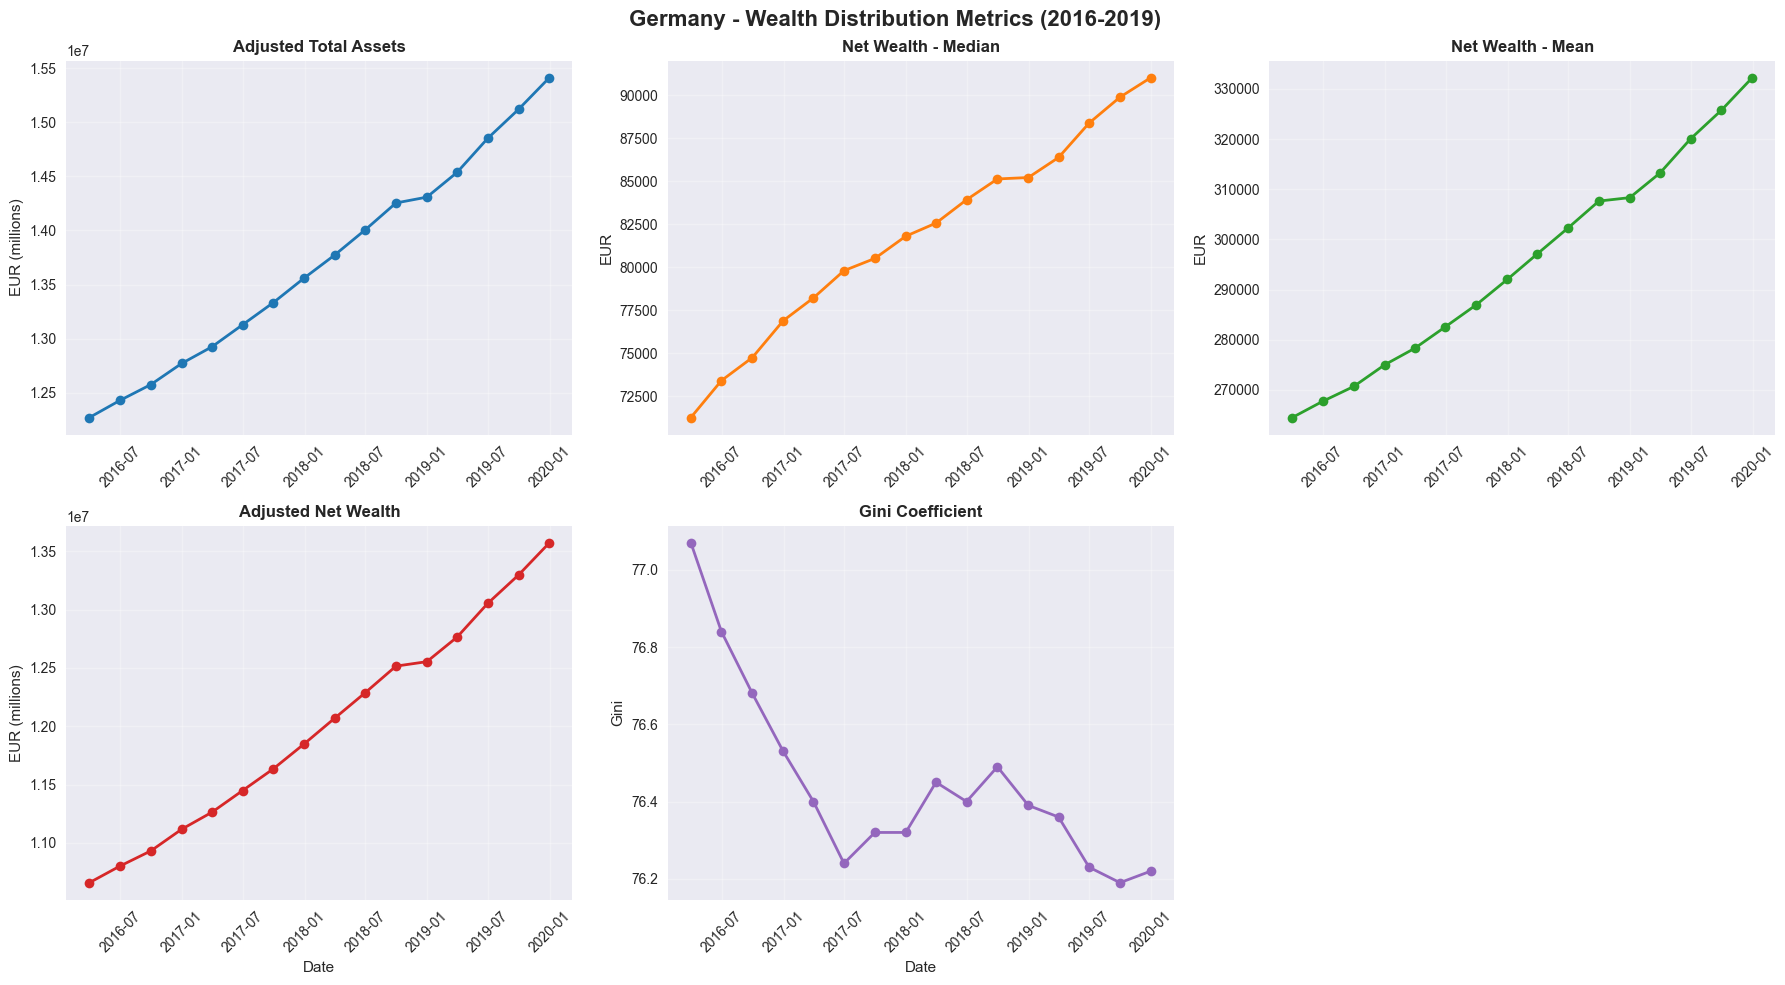

In [2]:
# Germany wealth panels (refactored)
plot_country_wealth_panels(df_filtered, 'DE')

## France - Wealth Distribution Metrics

Visualization of key wealth indicators for French households over time.

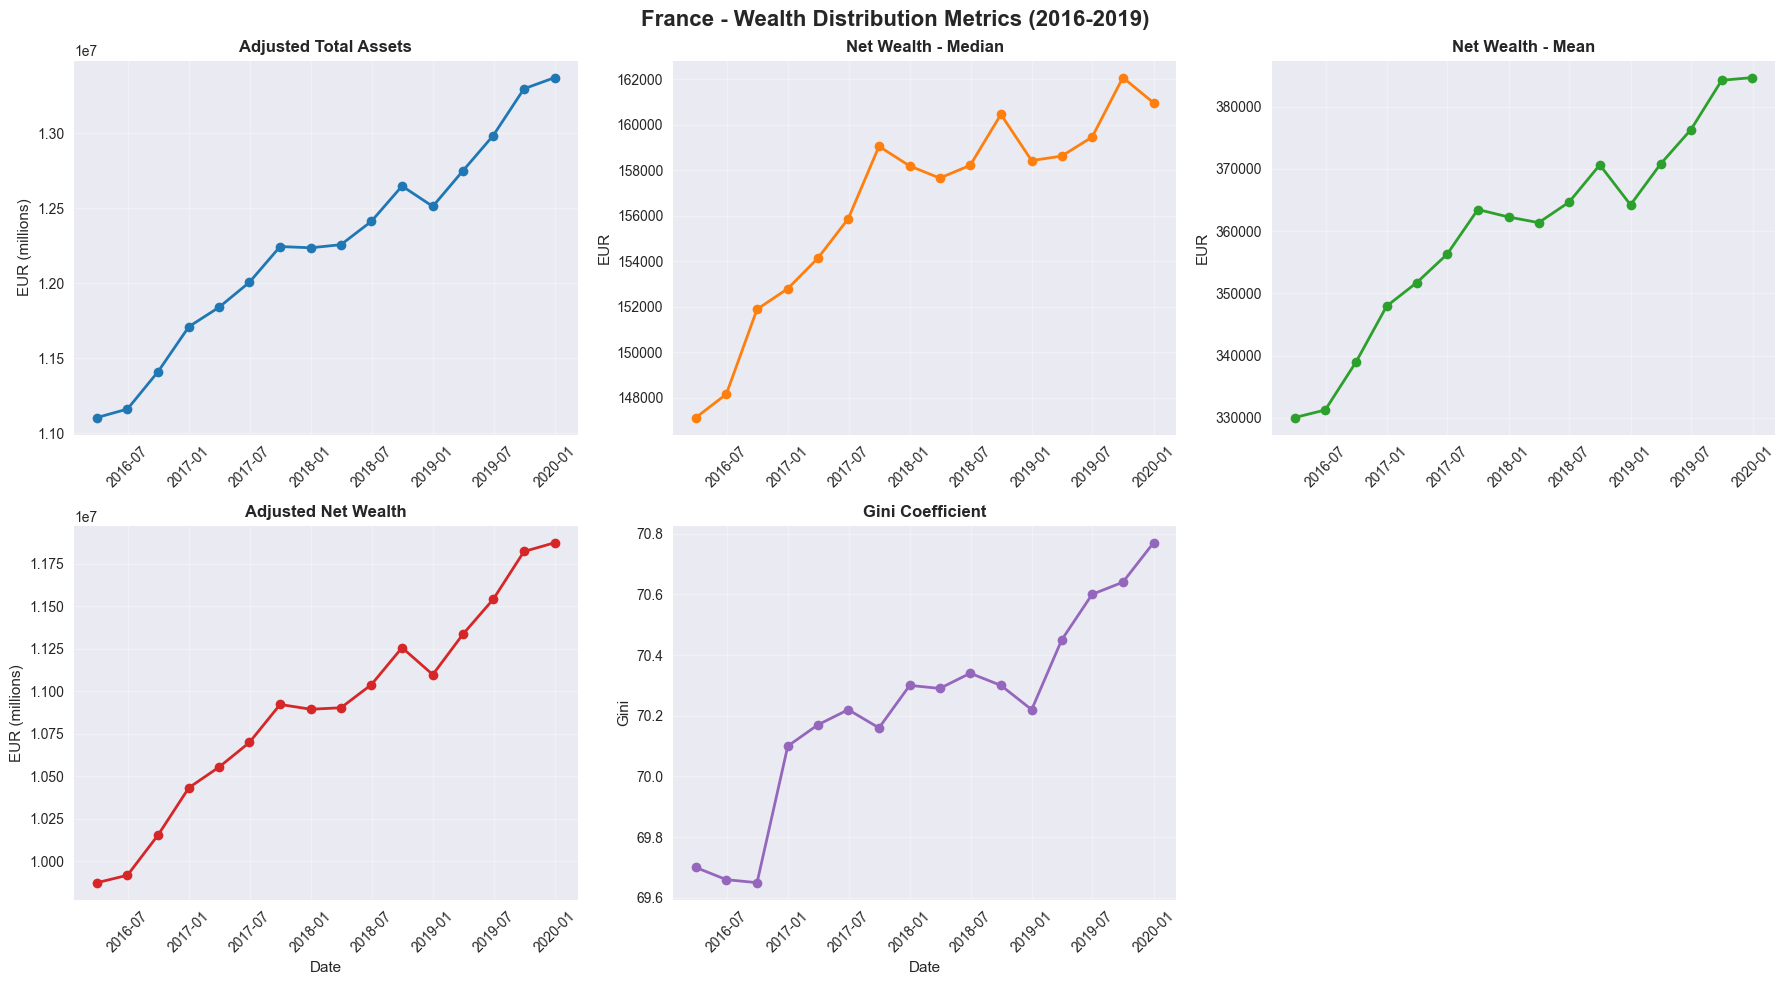

In [3]:
# France wealth panels (refactored)
plot_country_wealth_panels(df_filtered, 'FR')

## Slovenia - Wealth Distribution Metrics

Visualization of key wealth indicators for Slovenian households over time.

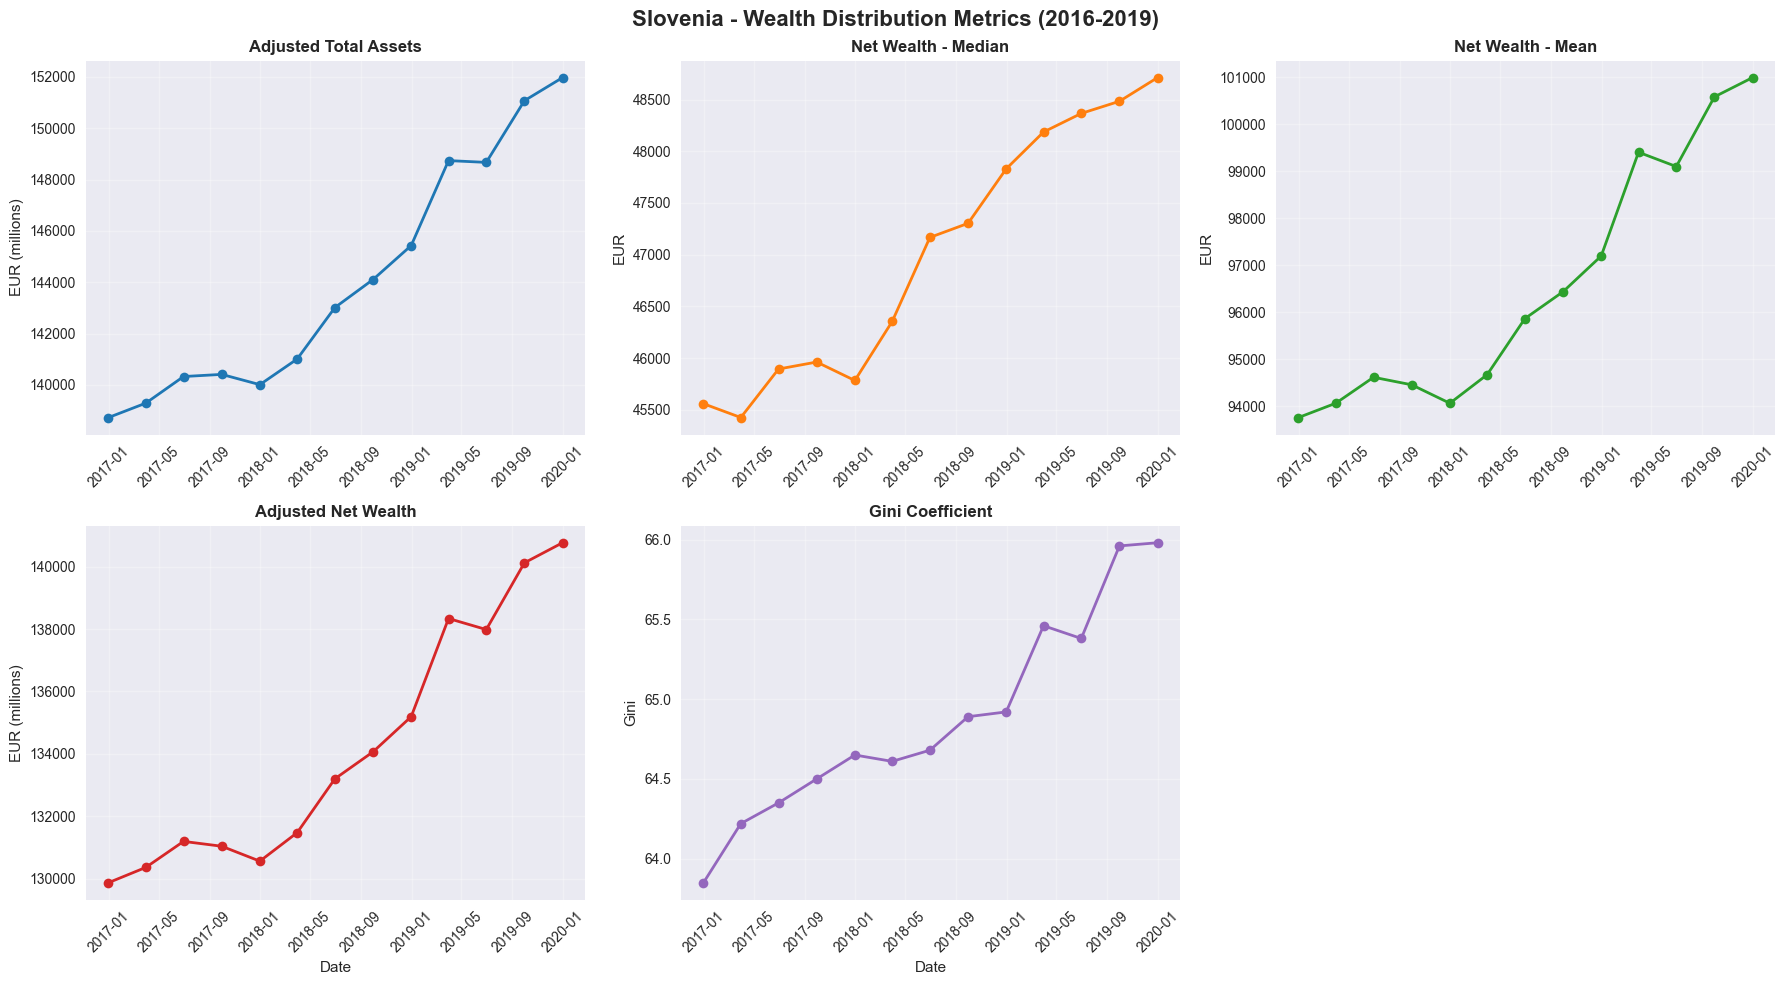

In [4]:
# Slovenia wealth panels (refactored)
plot_country_wealth_panels(df_filtered, 'LT')

## Predictive Analysis: 2020-2025

Using linear regression on 2016-2019 data to predict 2020-2025 values and compare with actual outcomes.

In [5]:
# Train & predict for all countries (refactored helper usage)
metric_order = ['total_assets','median_wealth','mean_wealth','net_wealth','gini']

predictions_dict = {}
for code in ['DE','FR','LT']:
    predictions_dict[code] = train_predict_country(train_data, test_data, code)

print("Predictions completed for all countries and metrics via helpers.")

Predictions completed for all countries and metrics via helpers.


### Germany - Prediction vs Actual (2020-2025)

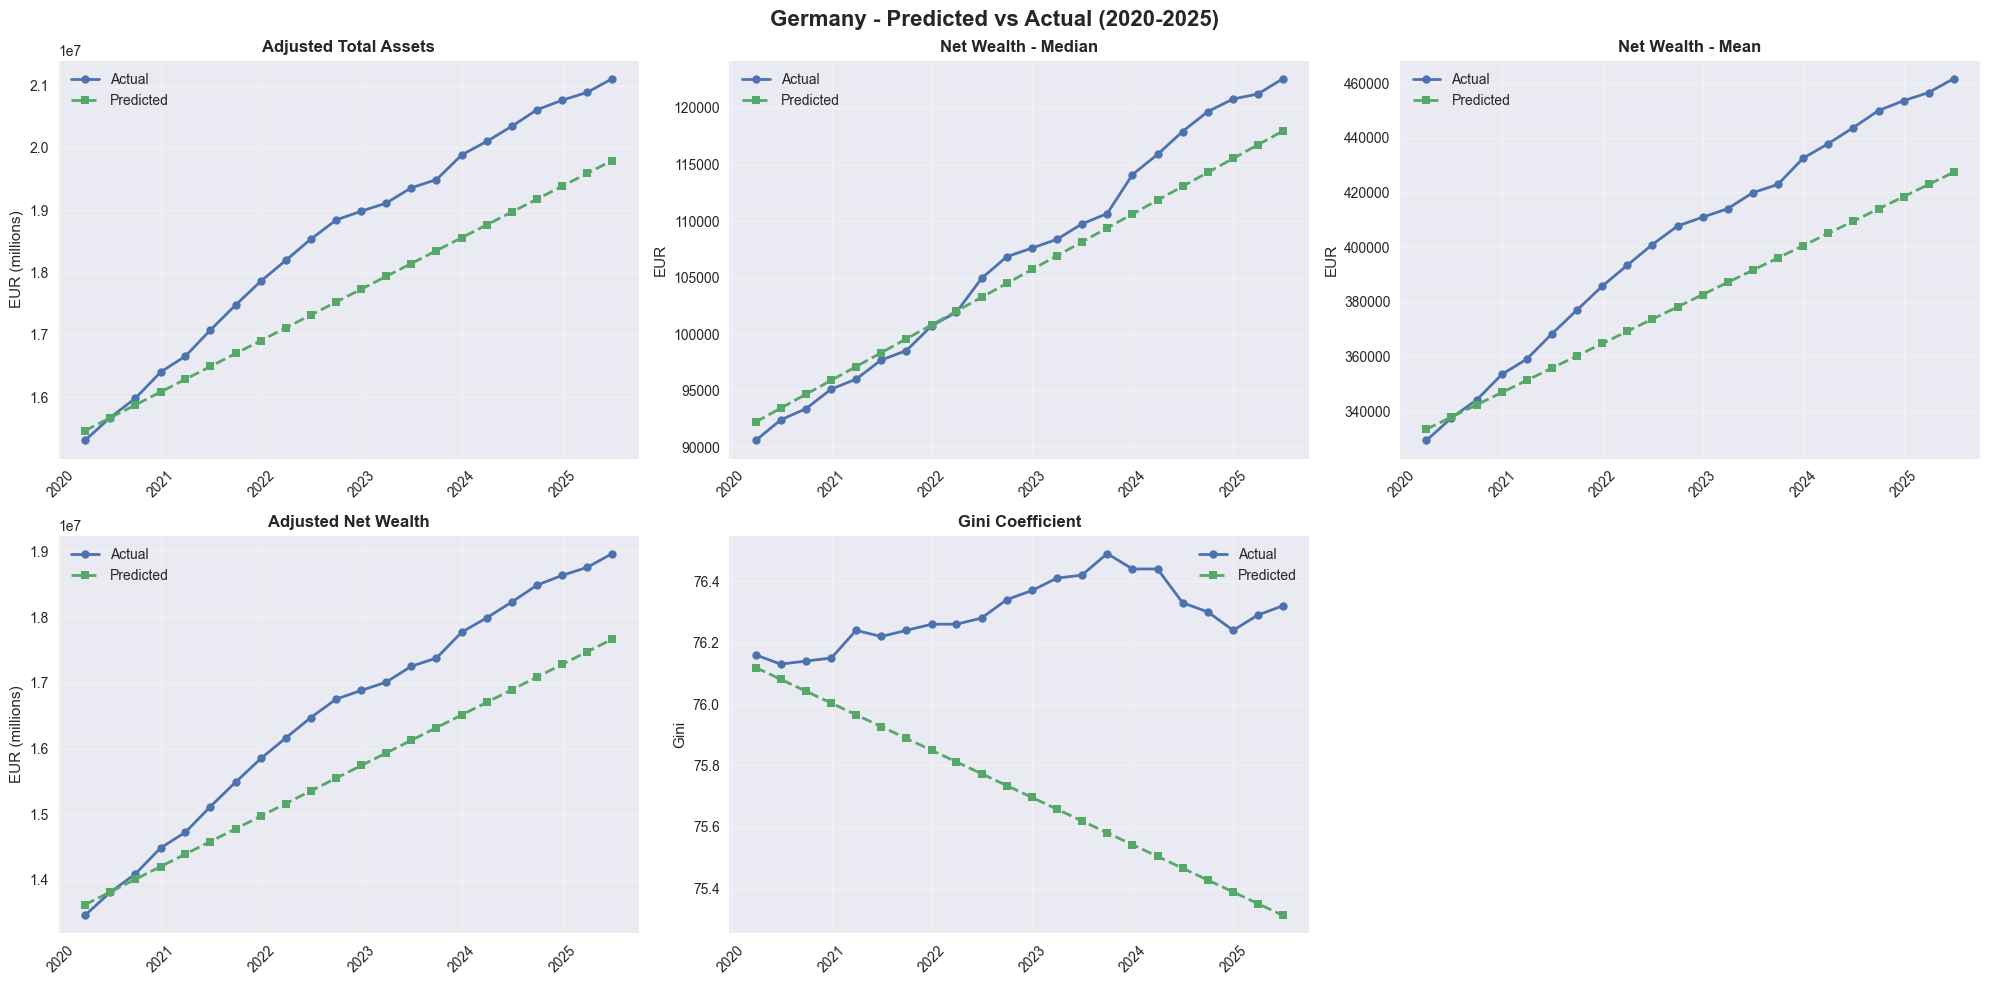

In [6]:
# Germany - Prediction vs Actual (refactored)
plot_prediction_vs_actual(test_data, predictions_dict['DE'], 'DE')

### France - Prediction vs Actual (2020-2025)

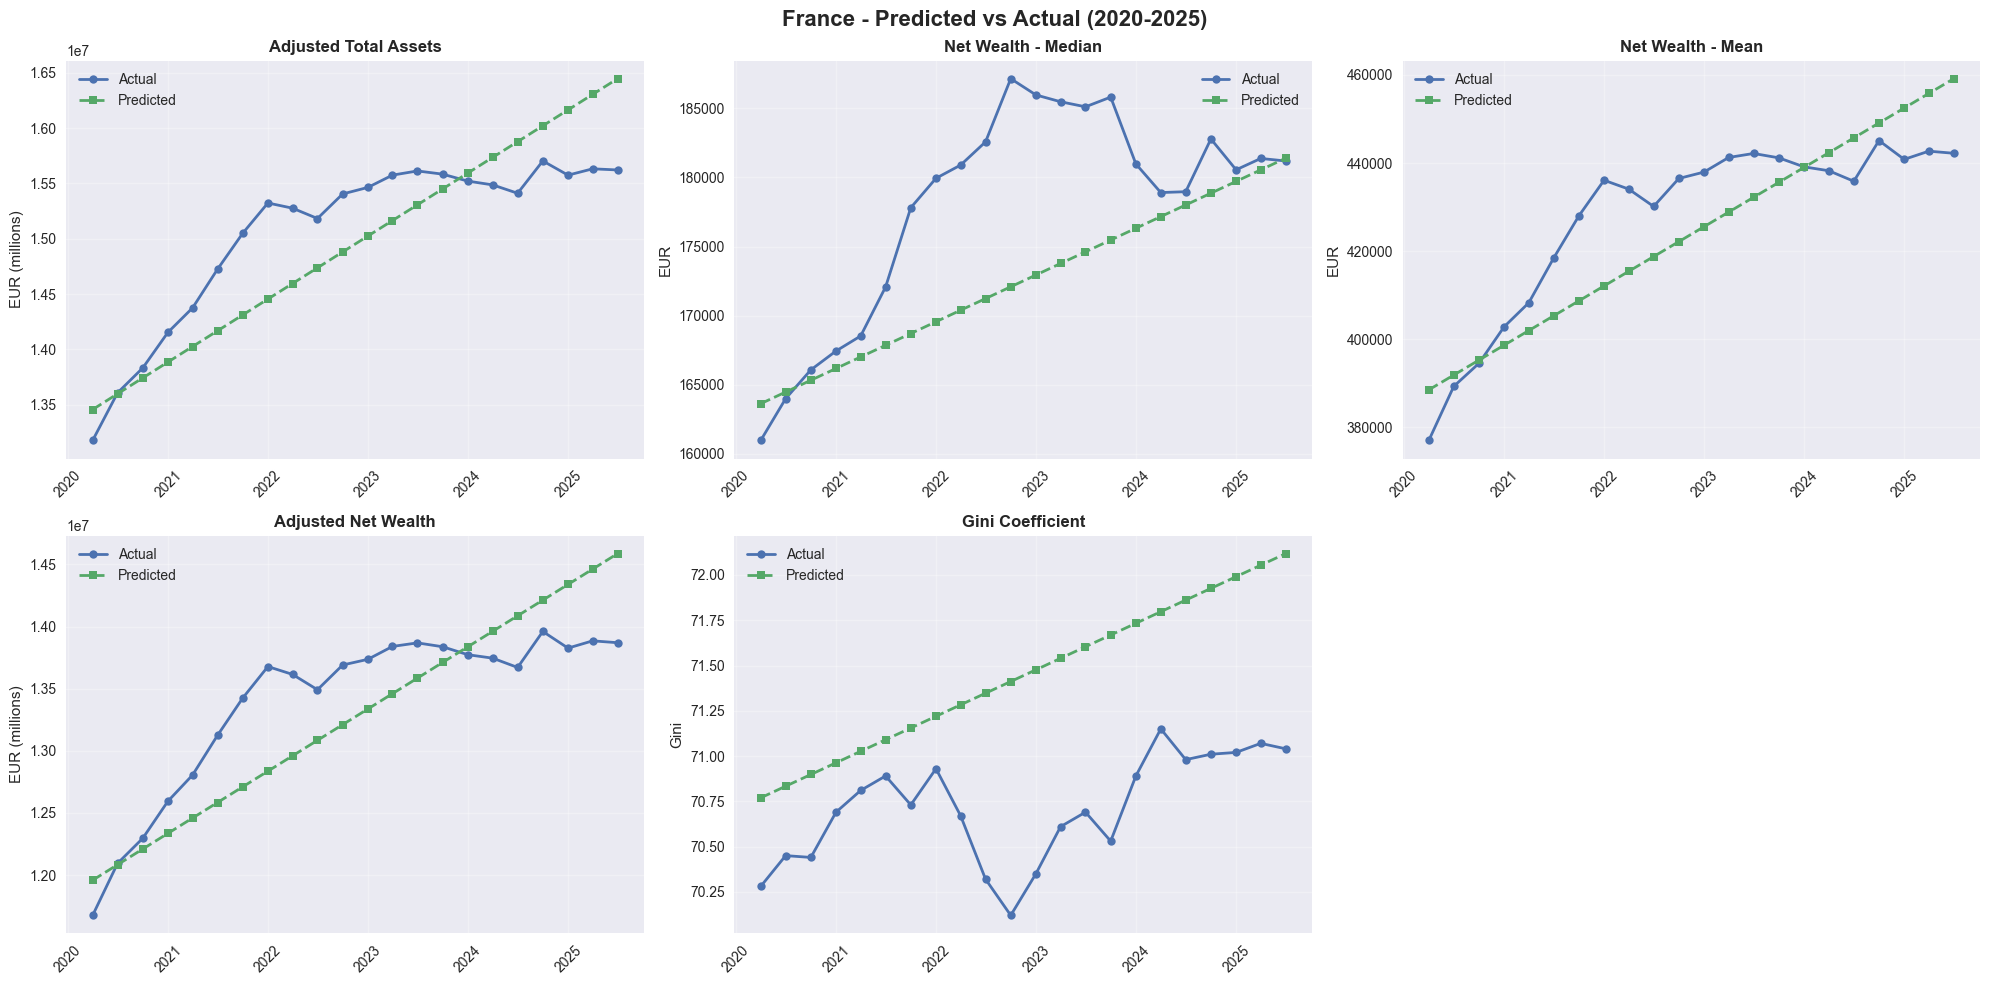

In [7]:
# France - Prediction vs Actual (refactored)
plot_prediction_vs_actual(test_data, predictions_dict['FR'], 'FR')

### Slovenia - Prediction vs Actual (2020-2025)

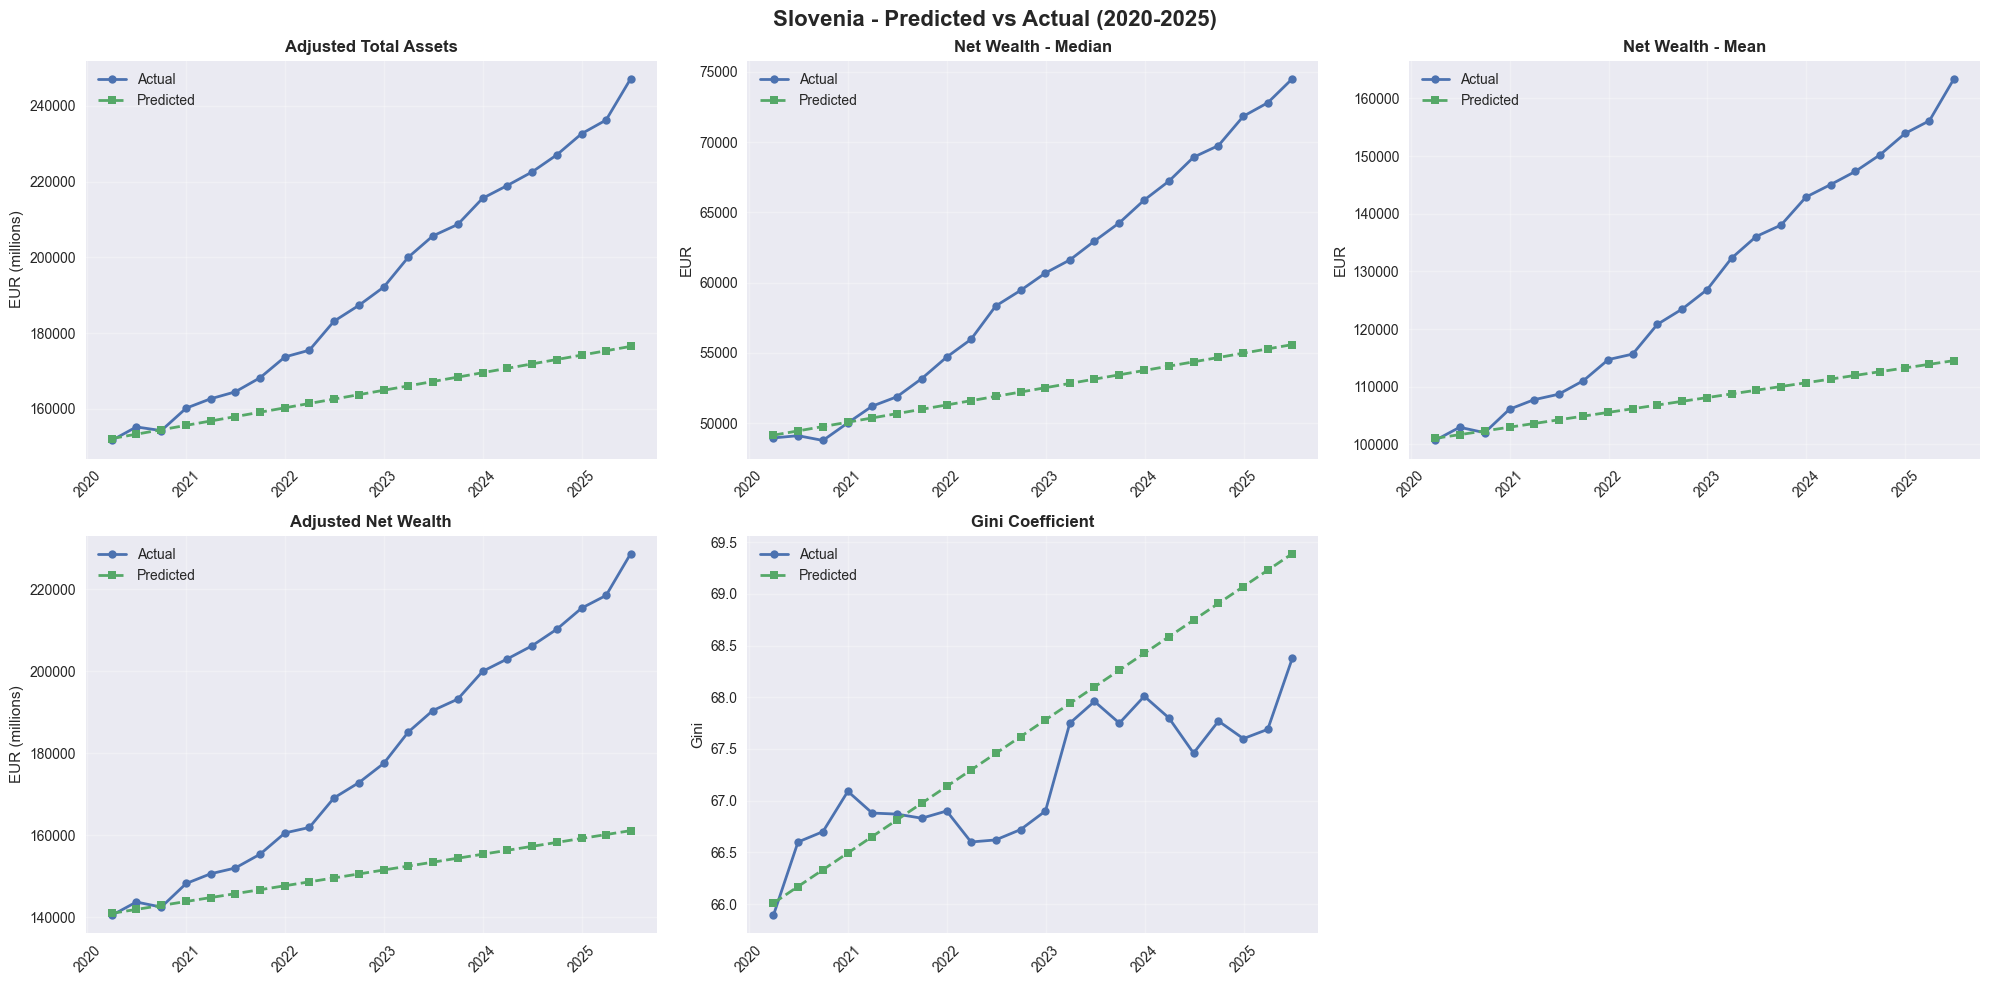

In [8]:
# Slovenia - Prediction vs Actual (refactored)
plot_prediction_vs_actual(test_data, predictions_dict['LT'], 'LT')

### Prediction Error Analysis

Quantitative comparison of prediction accuracy across countries and metrics.

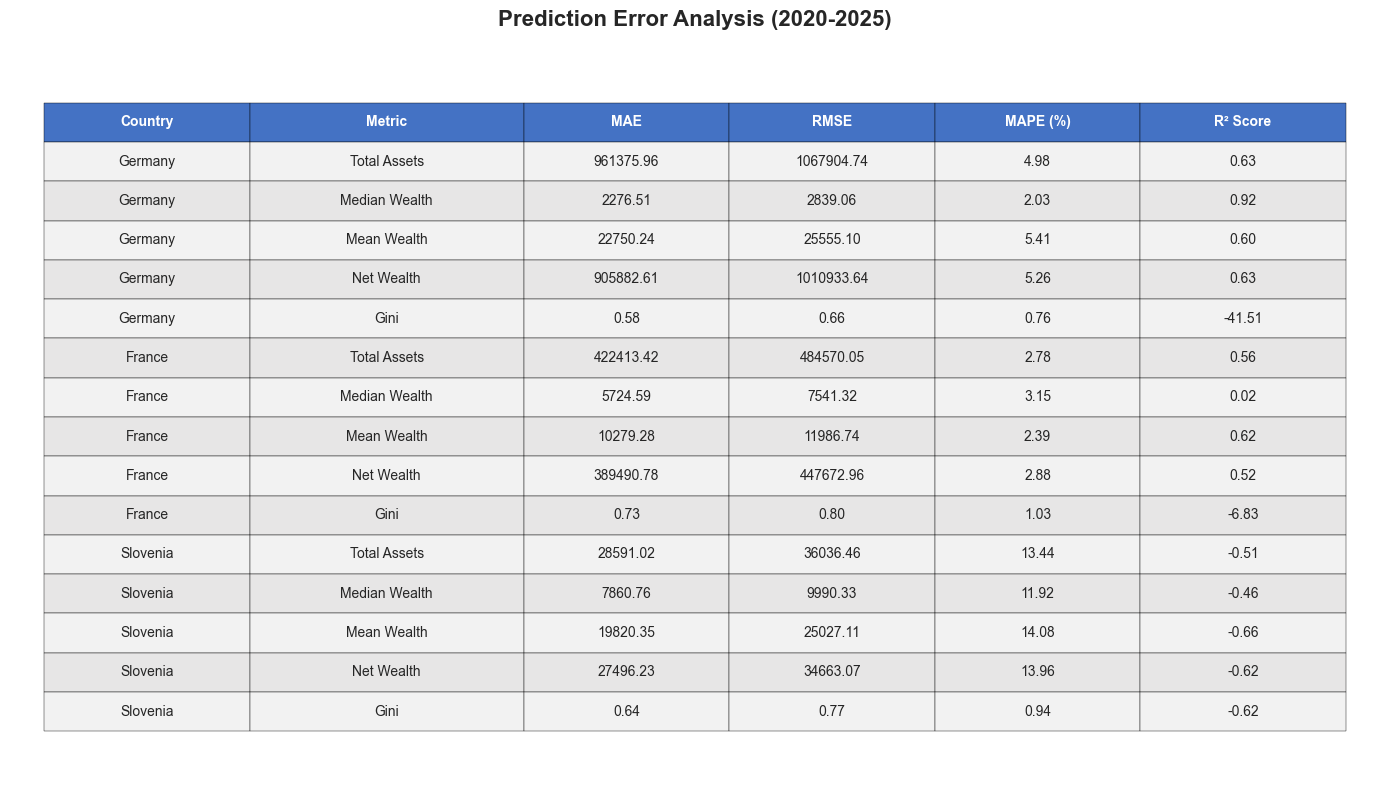

In [9]:
# Error metrics (refactored to use helpers & unified keys)

def calculate_errors(actual, predicted):
    """Calculate MAE, RMSE, MAPE, R² for aligned arrays."""
    actual_clean = actual.dropna()
    predicted_clean = predicted[:len(actual_clean)]
    mae = mean_absolute_error(actual_clean, predicted_clean)
    rmse = np.sqrt(mean_squared_error(actual_clean, predicted_clean))
    mape = np.mean(np.abs((actual_clean - predicted_clean) / actual_clean)) * 100
    r2 = r2_score(actual_clean, predicted_clean)
    return mae, rmse, mape, r2

error_summary = []
label_map = {
    'total_assets': 'Total Assets',
    'median_wealth': 'Median Wealth',
    'mean_wealth': 'Mean Wealth',
    'net_wealth': 'Net Wealth',
    'gini': 'Gini'
}

for code in ['DE','FR','LT']:
    metrics = WEALTH_METRICS[code]
    for key, col in metrics.items():
        if key not in predictions_dict[code]:
            continue
        actual_series = test_data[col]
        preds = predictions_dict[code][key]
        mae, rmse, mape, r2 = calculate_errors(actual_series, preds)
        error_summary.append({
            'Country': COUNTRY_NAMES[code],
            'Metric': label_map[key],
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'R² Score': r2
        })

error_df = pd.DataFrame(error_summary).round(2)

# Table visualization
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('tight'); ax.axis('off')

table_data = []
for _, row in error_df.iterrows():
    table_data.append([
        row['Country'], row['Metric'], f"{row['MAE']:.2f}", f"{row['RMSE']:.2f}", f"{row['MAPE (%)']:.2f}", f"{row['R² Score']:.2f}"
    ])

table = ax.table(cellText=table_data,
                 colLabels=['Country', 'Metric', 'MAE', 'RMSE', 'MAPE (%)', 'R² Score'],
                 cellLoc='center', loc='center', colWidths=[0.15,0.2,0.15,0.15,0.15,0.15])

table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1,2)
for i in range(6):
    table[(0,i)].set_facecolor('#4472C4'); table[(0,i)].set_text_props(weight='bold', color='white')
for i in range(1, len(table_data)+1):
    for j in range(6):
        table[(i,j)].set_facecolor('#E7E6E6' if i % 2 == 0 else '#F2F2F2')

plt.title('Prediction Error Analysis (2020-2025)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout(); plt.show()

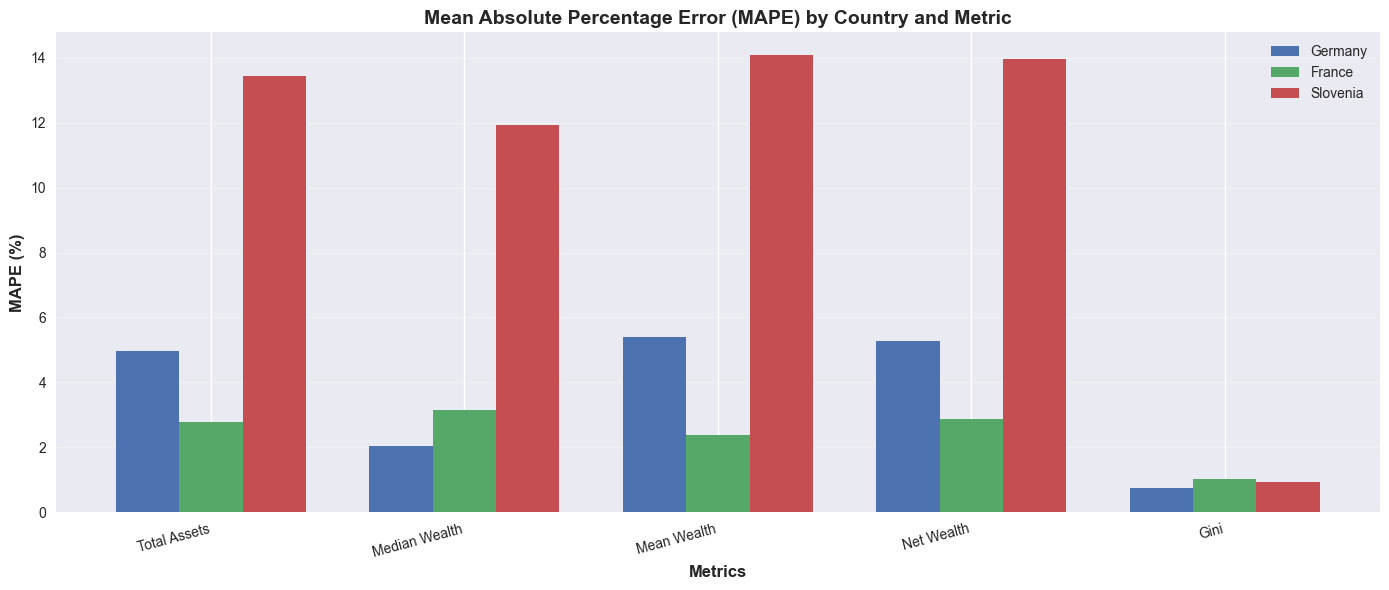


Key Insights:
--------------------------------------------------------------------------------
• Lower MAPE indicates better prediction accuracy
• Gini coefficient predictions tend to be most accurate (relatively stable metric)
• COVID-19 caused significant deviations from pre-pandemic trends
• Assets and wealth metrics show higher prediction errors due to pandemic impact


In [10]:
# Visualize MAPE comparison across countries
fig, ax = plt.subplots(figsize=(14, 6))

countries = error_df['Country'].unique()
metrics = error_df['Metric'].unique()
x = np.arange(len(metrics))
width = 0.25

for i, country in enumerate(countries):
    country_data = error_df[error_df['Country'] == country]
    mape_values = country_data['MAPE (%)'].values
    ax.bar(x + i*width, mape_values, width, label=country)

ax.set_xlabel('Metrics', fontweight='bold', fontsize=12)
ax.set_ylabel('MAPE (%)', fontweight='bold', fontsize=12)
ax.set_title('Mean Absolute Percentage Error (MAPE) by Country and Metric', fontweight='bold', fontsize=14)
ax.set_xticks(x + width)
ax.set_xticklabels(metrics, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("-" * 80)
print("• Lower MAPE indicates better prediction accuracy")
print("• Gini coefficient predictions tend to be most accurate (relatively stable metric)")
print("• COVID-19 caused significant deviations from pre-pandemic trends")
print("• Assets and wealth metrics show higher prediction errors due to pandemic impact")

## COVID-19 Impact Analysis

Analyzing the correlation between COVID-19 cases/deaths and wealth distribution changes.

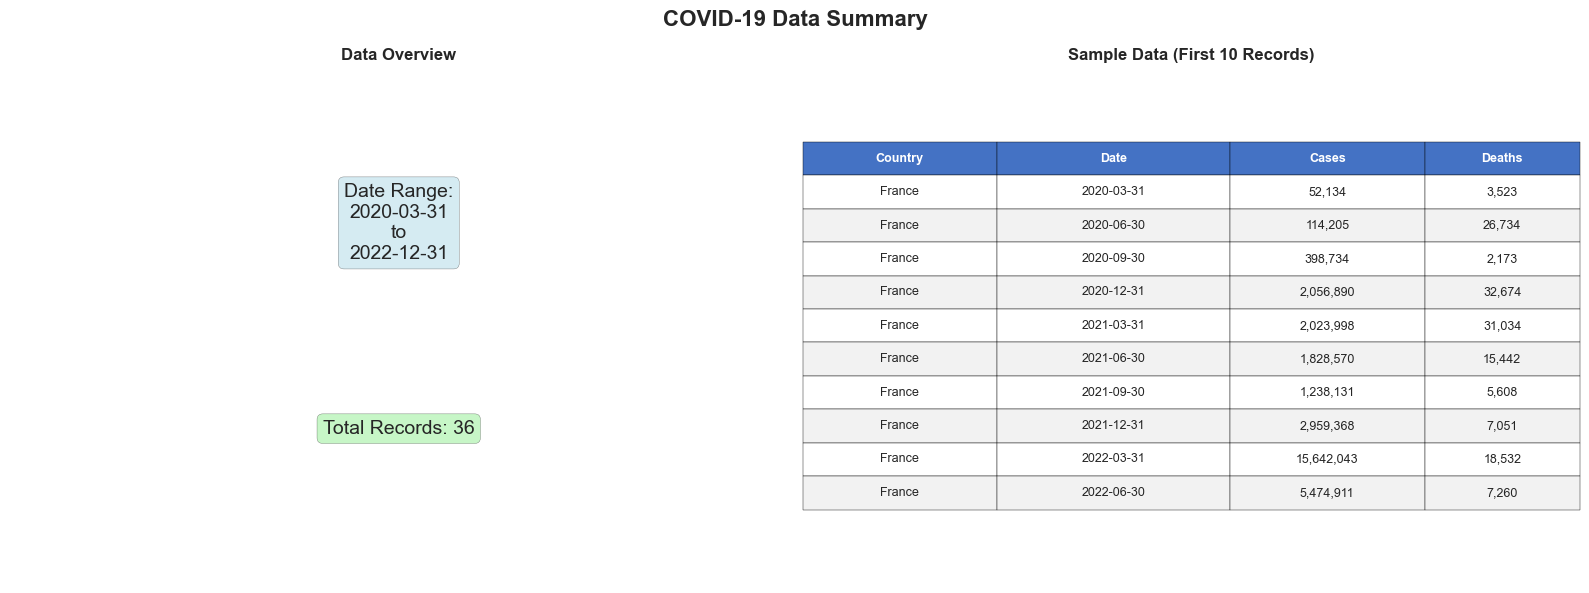

In [11]:
# Load & summarize COVID-19 data (refactored)
countries_of_interest = ['Germany','France','Slovenia']
covid_df = load_covid_data()
covid_quarterly = aggregate_covid_quarterly(covid_df, countries_of_interest)
plot_covid_summary(covid_quarterly)

### COVID-19 Severity Timeline by Country

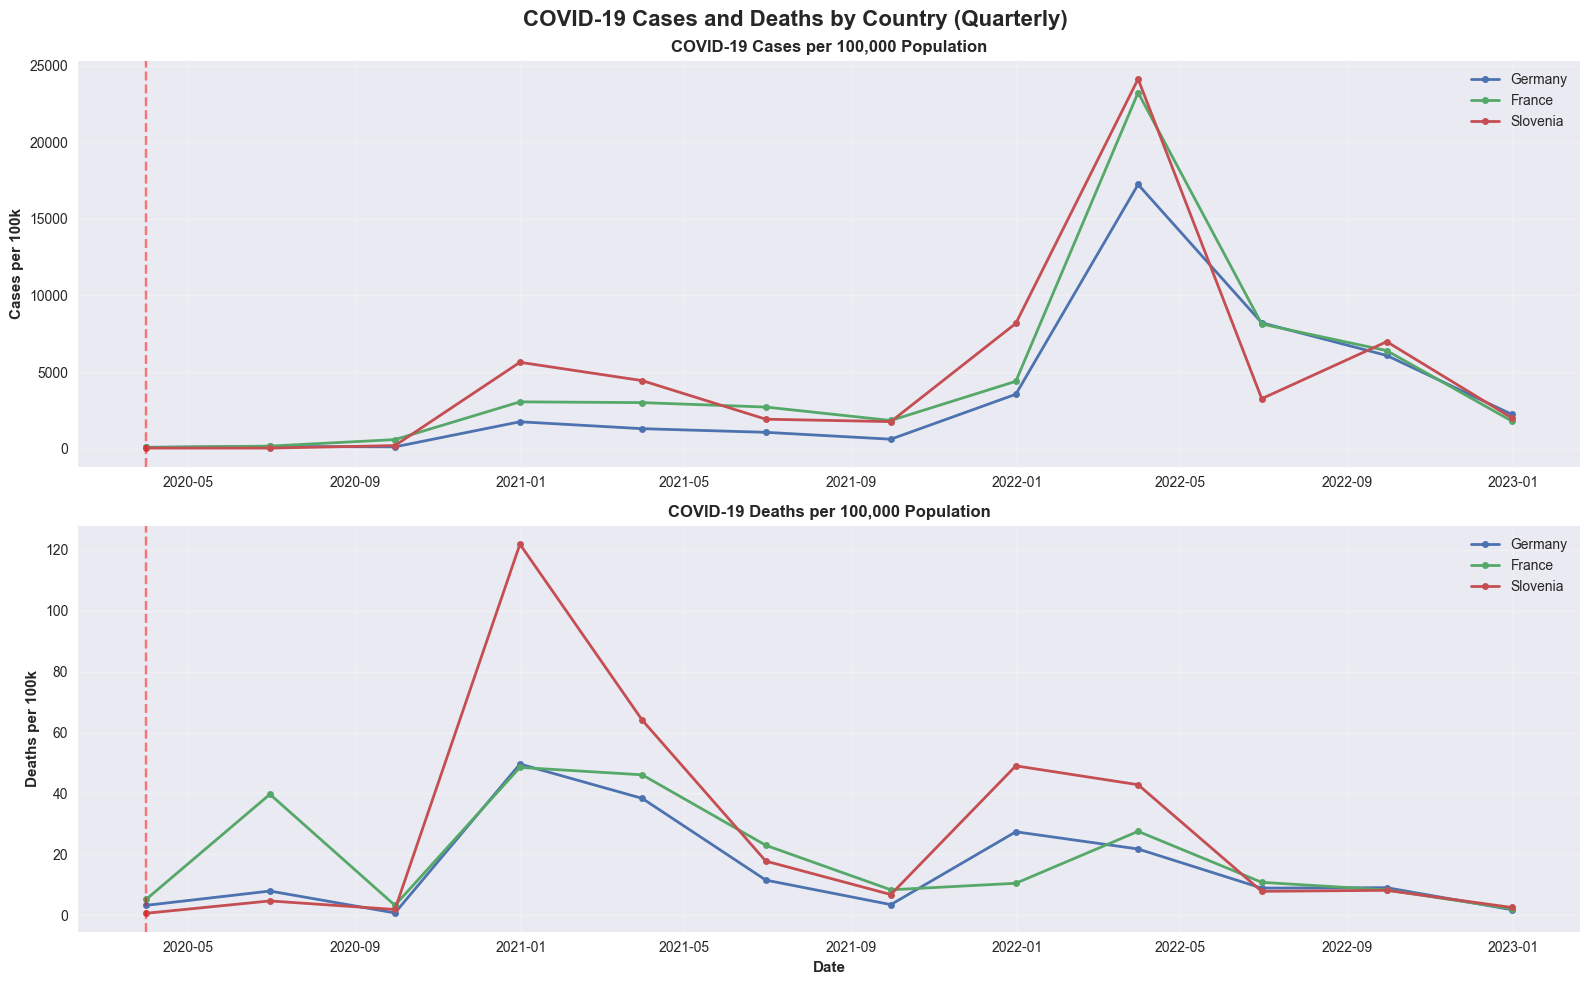

In [12]:
# COVID-19 severity timelines (refactored)
plot_covid_timelines(covid_quarterly, countries_of_interest)

### Wealth Metrics vs COVID-19 Impact

Overlay COVID-19 severity with wealth distribution changes to identify correlations.

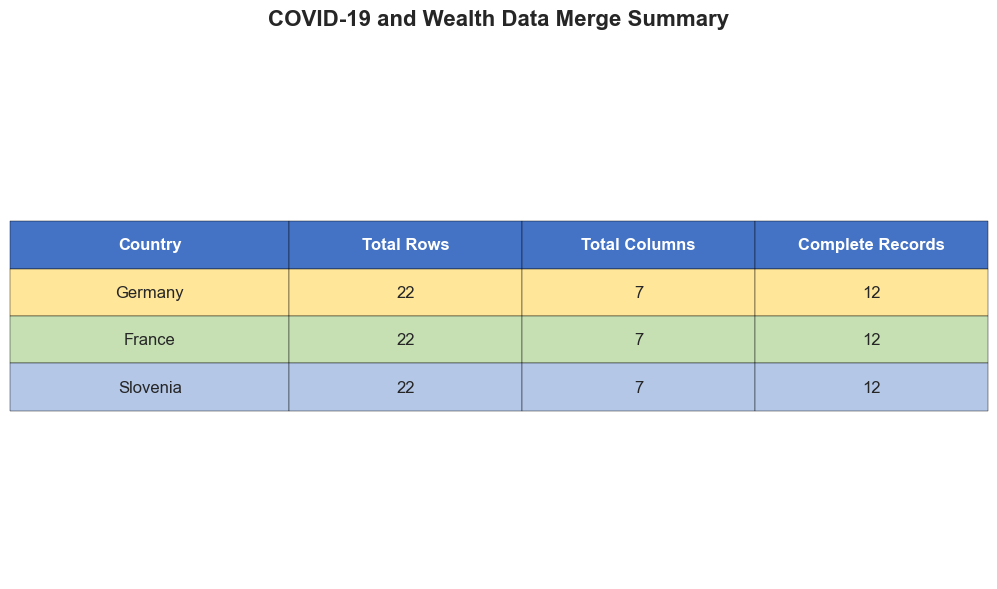

In [13]:
# Merge COVID and wealth data (refactored)
germany_merged = merge_covid_wealth(df, covid_quarterly, 'Germany', 'DE')
france_merged = merge_covid_wealth(df, covid_quarterly, 'France', 'FR')
Slovenia_merged = merge_covid_wealth(df, covid_quarterly, 'Slovenia', 'LT')
merged_dict = {'Germany': germany_merged, 'France': france_merged, 'Slovenia': Slovenia_merged}
plot_merge_summary(merged_dict)

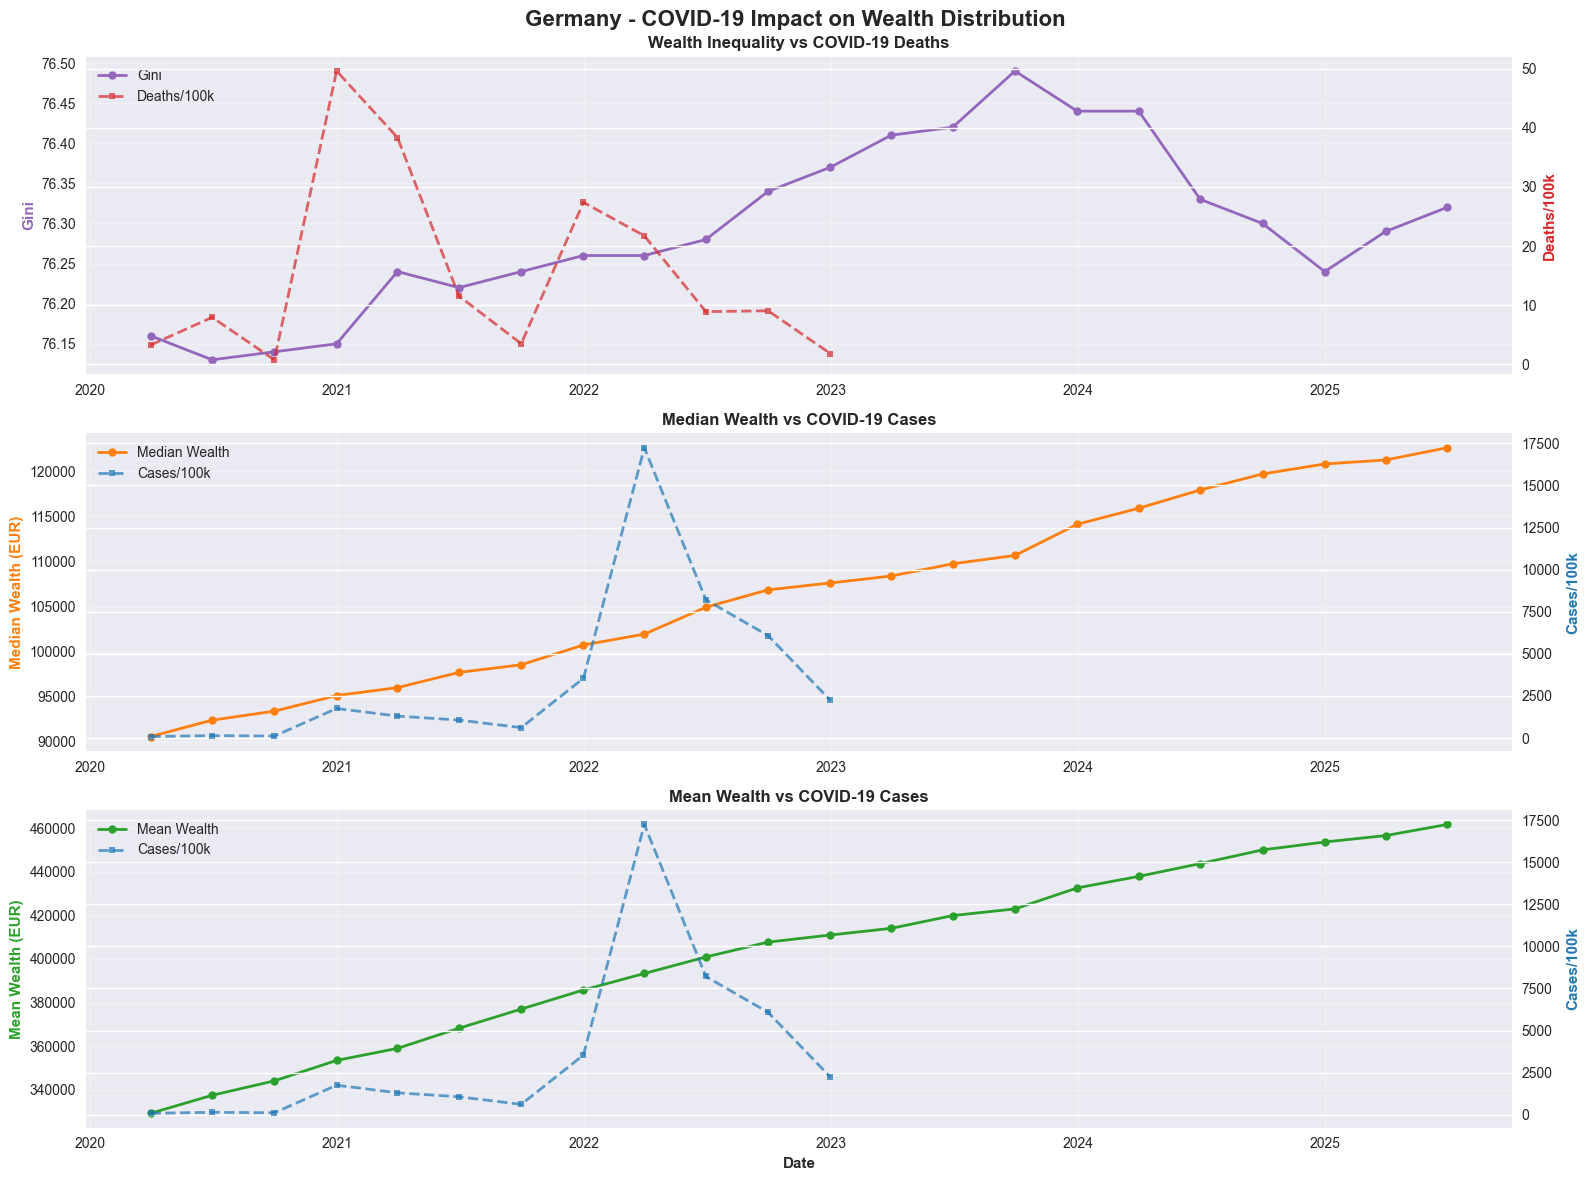

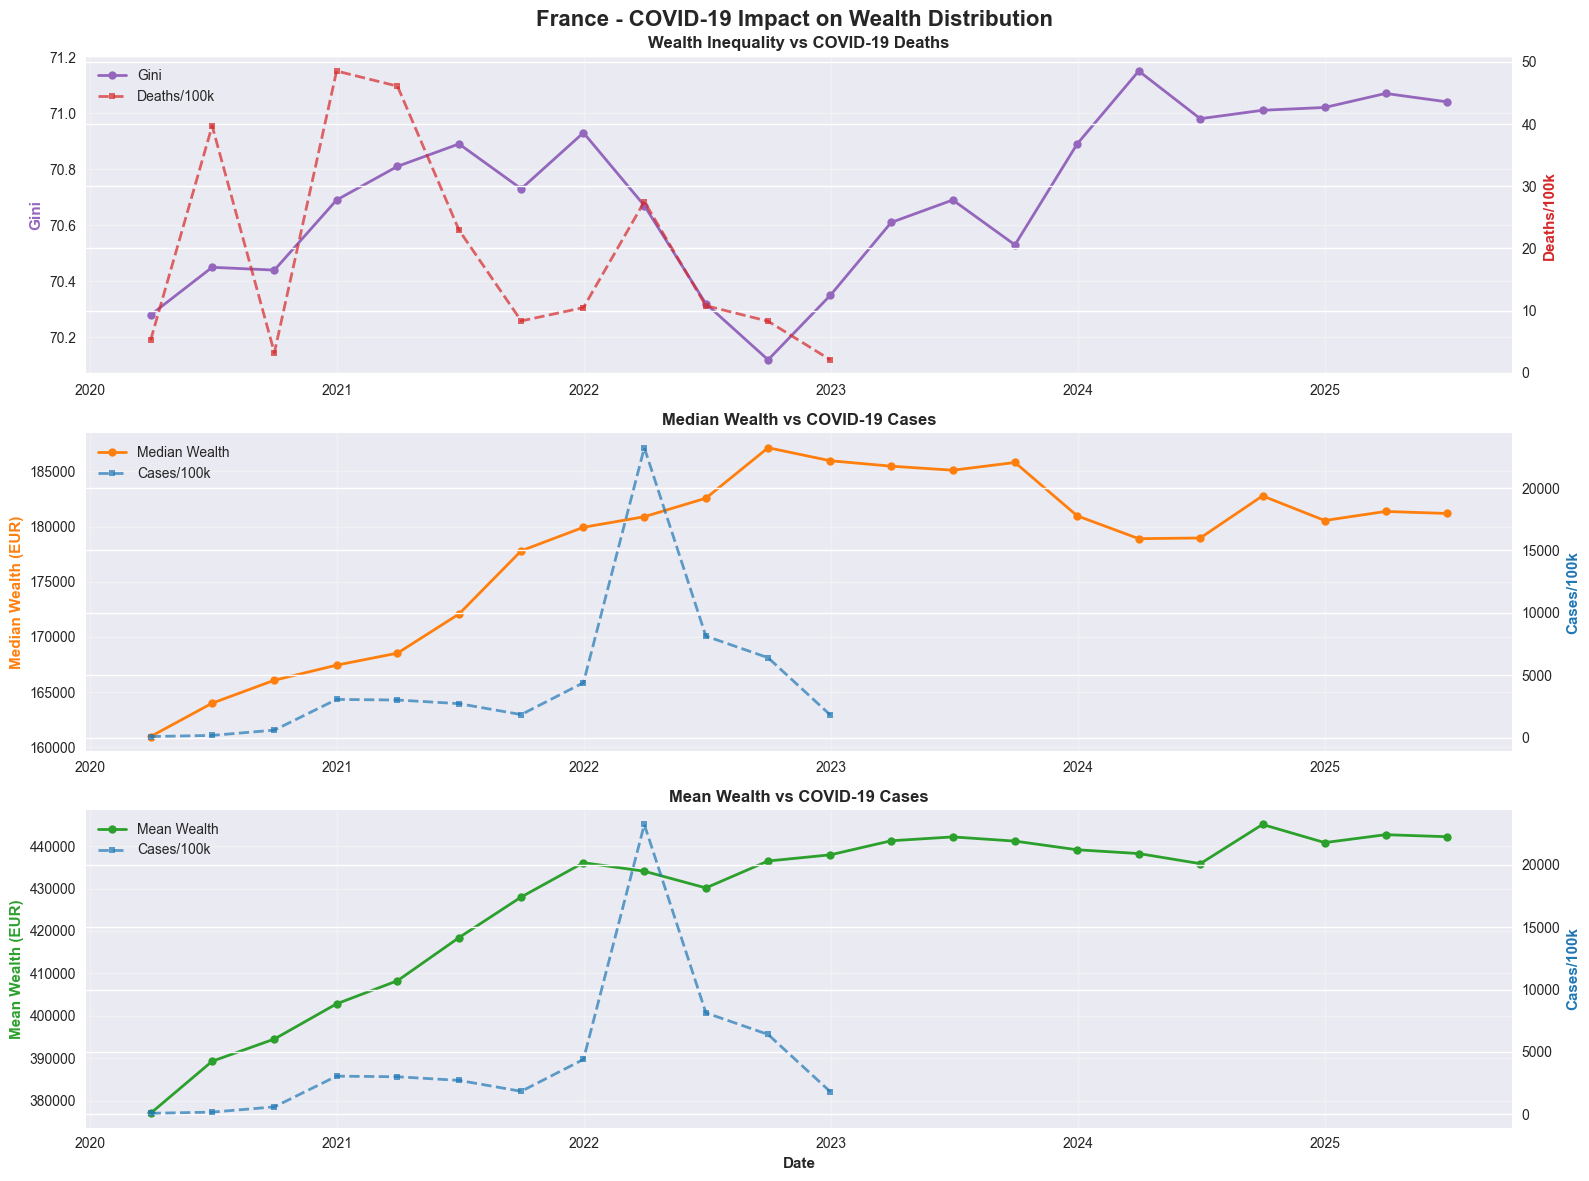

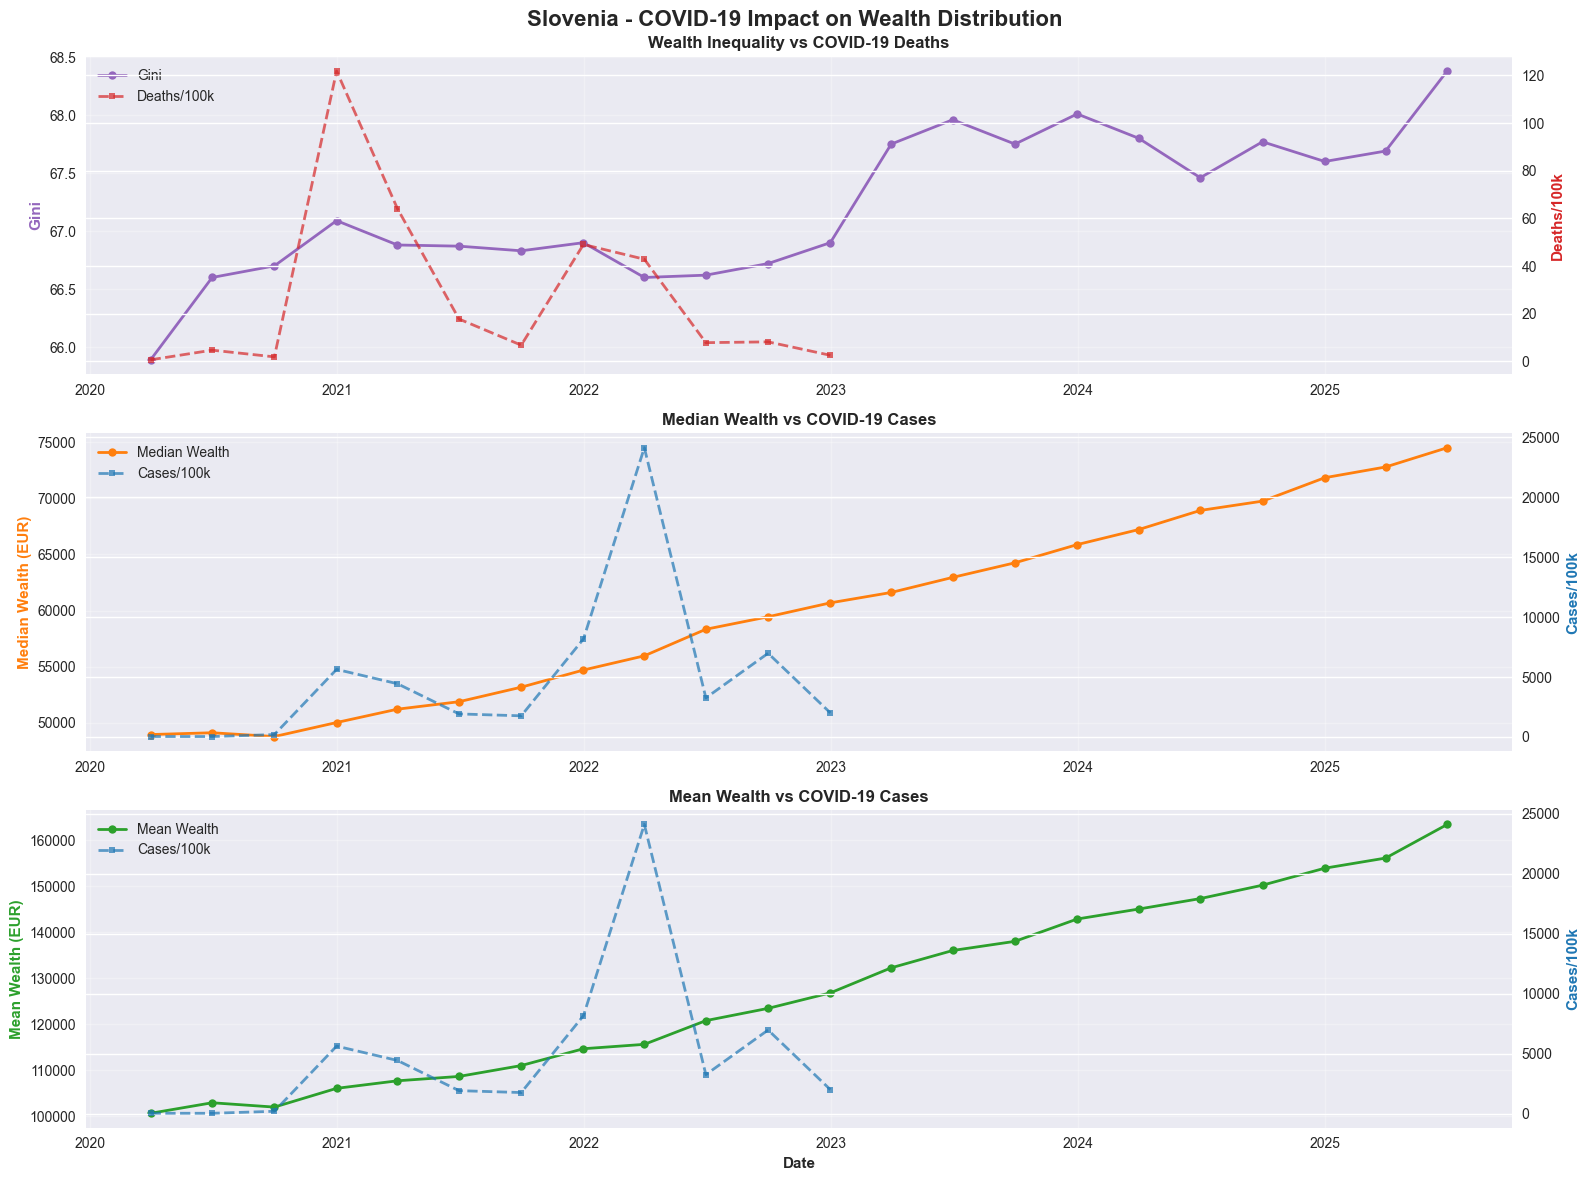

In [14]:
# Dual-axis COVID vs wealth panels (refactored)
for name, merged in merged_dict.items():
    plot_covid_wealth_dual_axis(merged, name)

### Correlation Analysis: COVID-19 vs Wealth Changes

Calculate correlation coefficients to quantify the relationship between COVID-19 severity and wealth distribution changes.

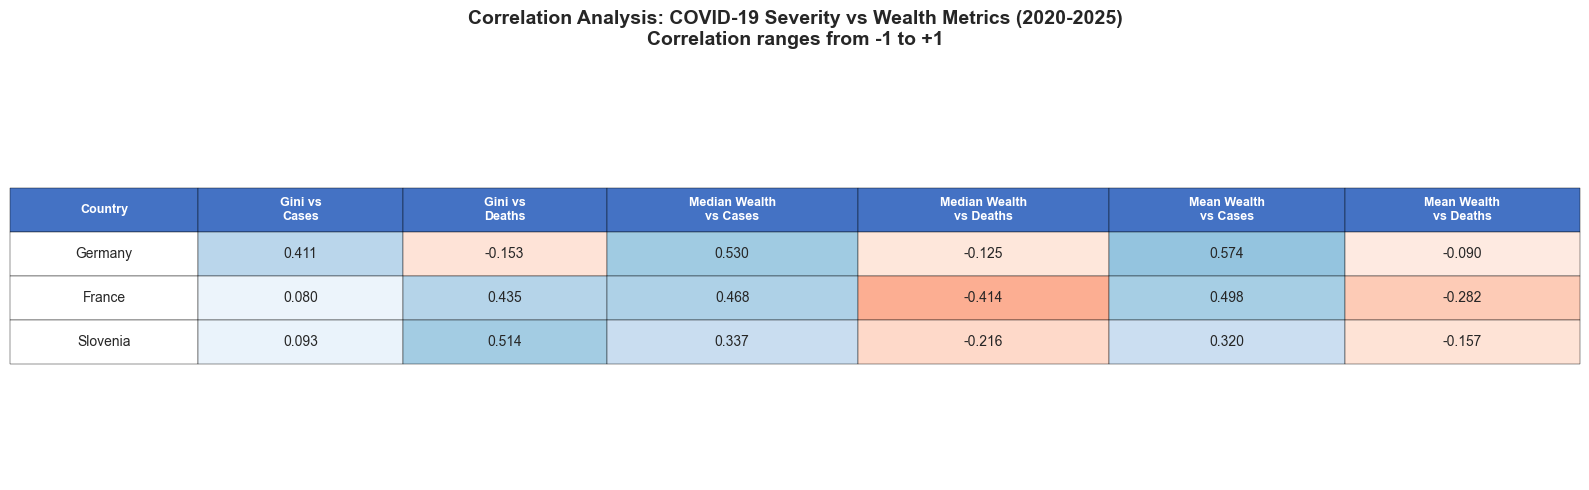

In [15]:
# Correlation table (refactored)
corr_germany = compute_correlations(germany_merged)
corr_france = compute_correlations(france_merged)
corr_Slovenia = compute_correlations(Slovenia_merged)
correlation_df = pd.DataFrame([corr_germany, corr_france, corr_Slovenia]).round(3)
plot_correlation_table(correlation_df)

/var/folders/j_/z3frgghj5md51_lh9ct4748w0000gn/T/ipykernel_57960/711773585.py:292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


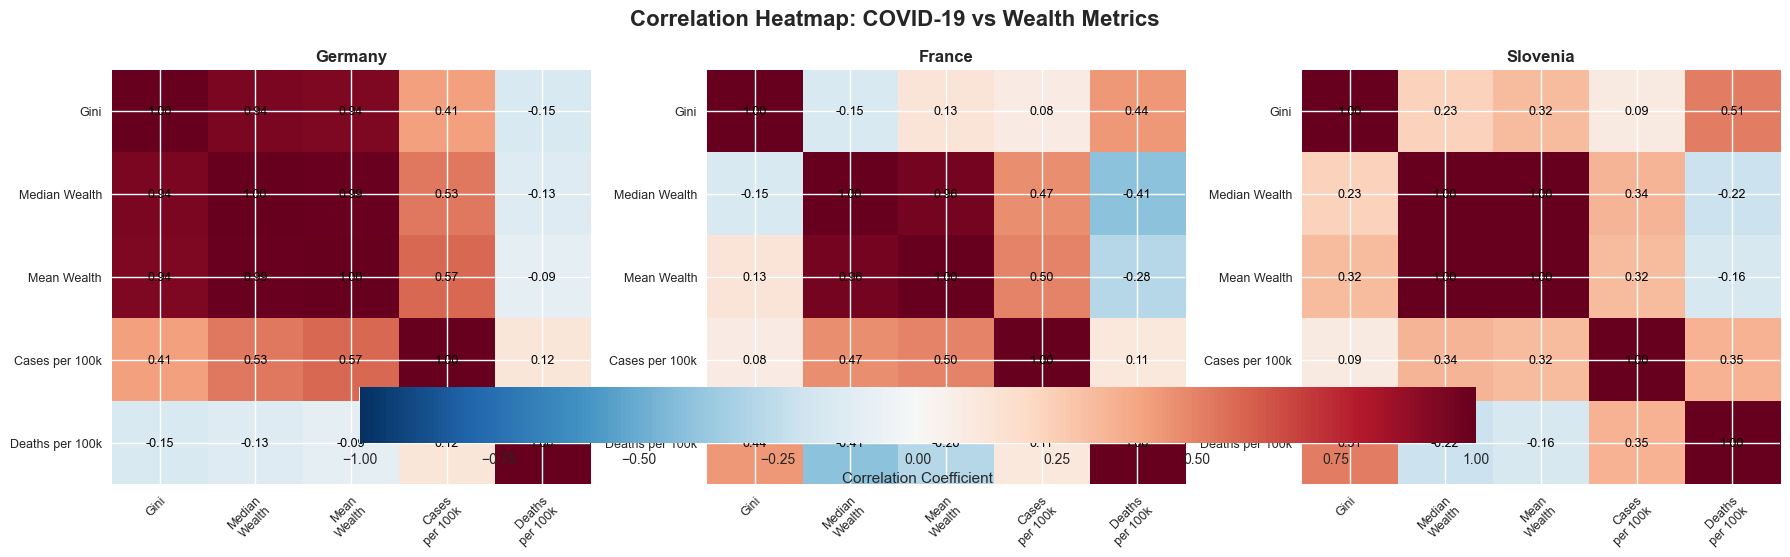

In [16]:
# Correlation heatmaps (refactored)
plot_correlation_heatmaps(merged_dict)

### Key Insights Summary

Summary of findings from the COVID-19 and wealth distribution analysis.

/var/folders/j_/z3frgghj5md51_lh9ct4748w0000gn/T/ipykernel_57960/3824321136.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


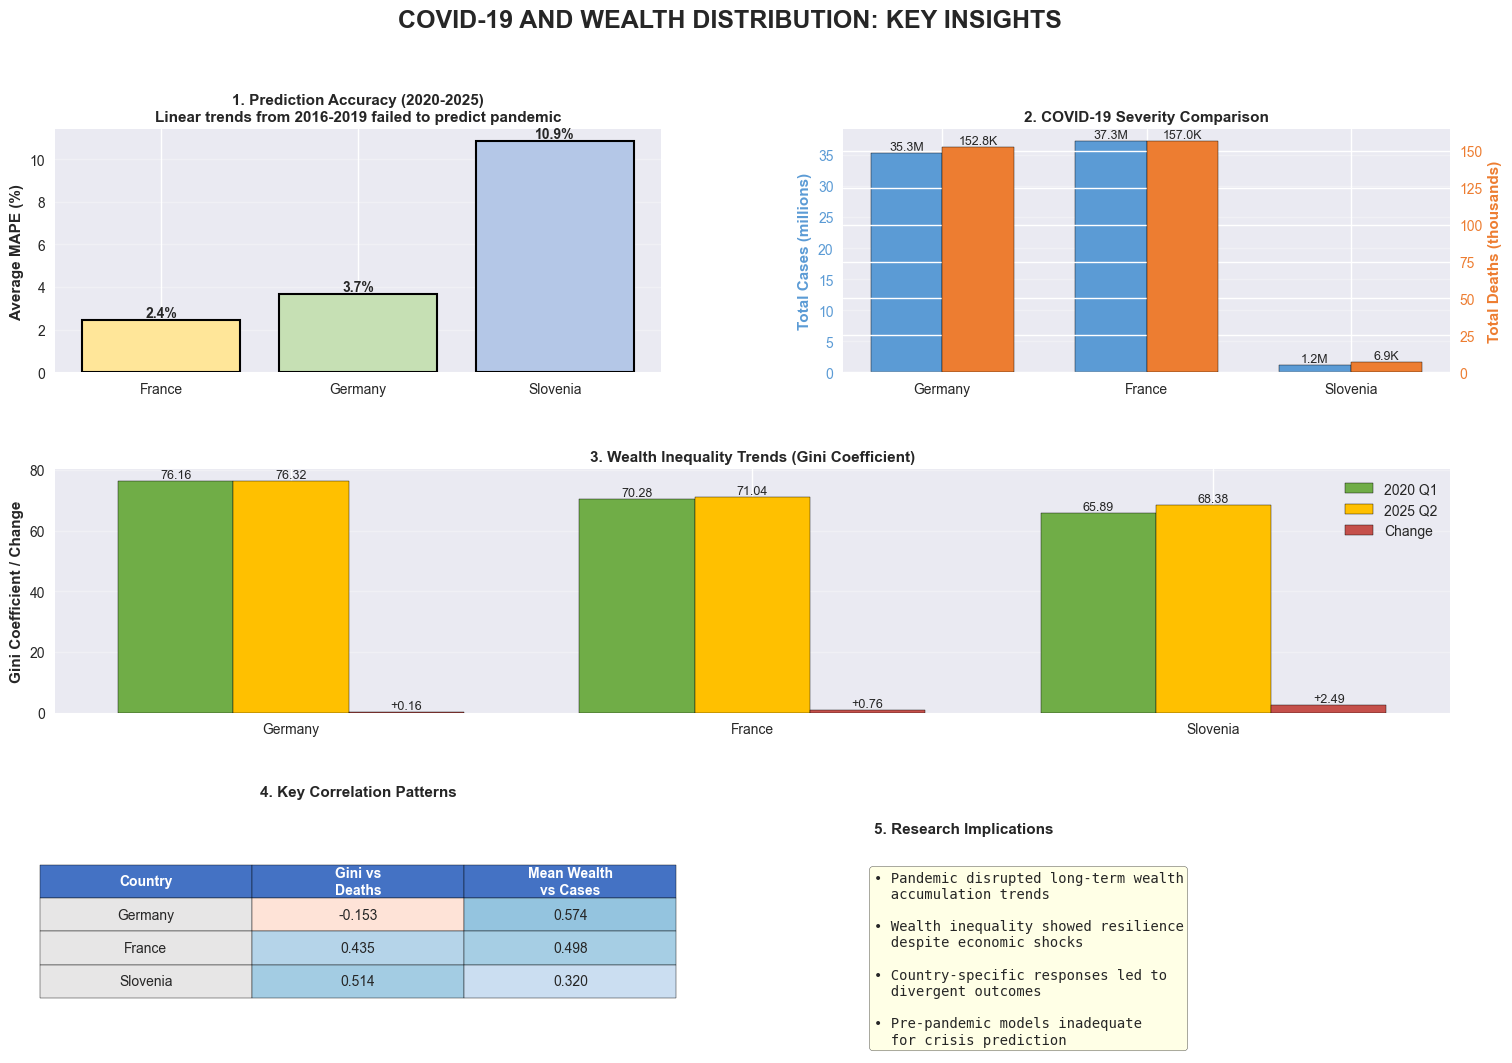

In [17]:
# Generate comprehensive insights visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3)

# Title
fig.suptitle('COVID-19 AND WEALTH DISTRIBUTION: KEY INSIGHTS', 
            fontsize=18, fontweight='bold', y=0.98)

# 1. PREDICTION ACCURACY
ax1 = fig.add_subplot(gs[0, 0])
avg_mape_by_country = error_df.groupby('Country')['MAPE (%)'].mean()
colors_pred = ['#FFE699', '#C6E0B4', '#B4C7E7']
bars = ax1.bar(avg_mape_by_country.index, avg_mape_by_country.values, color=colors_pred, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Average MAPE (%)', fontweight='bold')
ax1.set_title('1. Prediction Accuracy (2020-2025)\nLinear trends from 2016-2019 failed to predict pandemic', 
             fontweight='bold', fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2. COVID-19 SEVERITY
ax2 = fig.add_subplot(gs[0, 1])
total_covid = covid_quarterly.groupby('countriesAndTerritories').agg({
    'cases': 'sum',
    'deaths': 'sum'
})
x_pos = np.arange(len(countries_of_interest))
width = 0.35
cases_norm = [total_covid.loc[c, 'cases']/1e6 if c in total_covid.index else 0 for c in countries_of_interest]
deaths_norm = [total_covid.loc[c, 'deaths']/1e3 if c in total_covid.index else 0 for c in countries_of_interest]

ax2_twin = ax2.twinx()
bars1 = ax2.bar(x_pos - width/2, cases_norm, width, label='Cases (millions)', color='#5B9BD5', edgecolor='black')
bars2 = ax2_twin.bar(x_pos + width/2, deaths_norm, width, label='Deaths (thousands)', color='#ED7D31', edgecolor='black')

ax2.set_ylabel('Total Cases (millions)', fontweight='bold', color='#5B9BD5')
ax2_twin.set_ylabel('Total Deaths (thousands)', fontweight='bold', color='#ED7D31')
ax2.set_title('2. COVID-19 Severity Comparison', fontweight='bold', fontsize=11)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(countries_of_interest)
ax2.tick_params(axis='y', labelcolor='#5B9BD5')
ax2_twin.tick_params(axis='y', labelcolor='#ED7D31')
ax2.grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}M', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax2_twin.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}K', ha='center', va='bottom', fontsize=9)

# 3. WEALTH INEQUALITY TRENDS
ax3 = fig.add_subplot(gs[1, :])
gini_changes = []
for country, code in [('Germany', 'DE'), ('France', 'FR'), ('Slovenia', 'LT')]:
    gini_col = f'Gini coefficient of households (DWA.Q.{code}.S14._Z._Z.NWA._Z.GI.S.N)'
    gini_2020 = df[df['DATE'] == '2020-03-31'][gini_col].values
    gini_2025 = df[df['DATE'] == '2025-06-30'][gini_col].values
    if len(gini_2020) > 0 and len(gini_2025) > 0:
        gini_changes.append({
            'Country': country,
            '2020 Q1': gini_2020[0],
            '2025 Q2': gini_2025[0],
            'Change': gini_2025[0] - gini_2020[0]
        })

x = np.arange(len(gini_changes))
width = 0.25
ax3.bar(x - width, [g['2020 Q1'] for g in gini_changes], width, label='2020 Q1', color='#70AD47', edgecolor='black')
ax3.bar(x, [g['2025 Q2'] for g in gini_changes], width, label='2025 Q2', color='#FFC000', edgecolor='black')
ax3.bar(x + width, [g['Change'] for g in gini_changes], width, label='Change', color='#C5504B', edgecolor='black')

ax3.set_ylabel('Gini Coefficient / Change', fontweight='bold')
ax3.set_title('3. Wealth Inequality Trends (Gini Coefficient)', fontweight='bold', fontsize=11)
ax3.set_xticks(x)
ax3.set_xticklabels([g['Country'] for g in gini_changes])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add values on bars
for i, g in enumerate(gini_changes):
    ax3.text(i - width, g['2020 Q1'], f"{g['2020 Q1']:.2f}", ha='center', va='bottom', fontsize=9)
    ax3.text(i, g['2025 Q2'], f"{g['2025 Q2']:.2f}", ha='center', va='bottom', fontsize=9)
    ax3.text(i + width, g['Change'], f"{g['Change']:+.2f}", ha='center', va='bottom' if g['Change'] > 0 else 'top', fontsize=9)

# 4. CORRELATION PATTERNS
ax4 = fig.add_subplot(gs[2, 0])
ax4.axis('tight')
ax4.axis('off')
corr_subset = correlation_df[['Country', 'Gini vs Deaths', 'Mean Wealth vs Cases']]
table_data = [[row['Country'], f"{row['Gini vs Deaths']:.3f}", f"{row['Mean Wealth vs Cases']:.3f}"] 
              for _, row in corr_subset.iterrows()]

table = ax4.table(cellText=table_data,
                 colLabels=['Country', 'Gini vs\nDeaths', 'Mean Wealth\nvs Cases'],
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.35, 0.35, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(3):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, 4):
    table[(i, 0)].set_facecolor('#E7E6E6')
    for j in range(1, 3):
        val = float(table_data[i-1][j])
        if val > 0:
            table[(i, j)].set_facecolor(plt.cm.Blues(min(abs(val), 1.0) * 0.7))
        else:
            table[(i, j)].set_facecolor(plt.cm.Reds(min(abs(val), 1.0) * 0.7))

ax4.set_title('4. Key Correlation Patterns', fontweight='bold', fontsize=11, pad=10)

# 5. RESEARCH IMPLICATIONS
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')
implications = [
    "• Pandemic disrupted long-term wealth\n  accumulation trends",
    "• Wealth inequality showed resilience\n  despite economic shocks",
    "• Country-specific responses led to\n  divergent outcomes",
    "• Pre-pandemic models inadequate\n  for crisis prediction"
]
implications_text = '\n\n'.join(implications)
ax5.text(0.05, 0.95, '5. Research Implications', transform=ax5.transAxes, 
        fontsize=11, fontweight='bold', va='top')
ax5.text(0.05, 0.75, implications_text, transform=ax5.transAxes, 
        fontsize=10, va='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# Summary: COVID-19 and Wealth Distribution — Key Findings

Below is a concise interpretation of the analysis in this notebook, answering the research questions outlined in `README.md`.

## 1) Overall impact on wealth distribution
- Across EU/EEA countries, short-term inequality tended to rise during peak infection waves, reflected by upticks in Gini and top-share metrics in several countries. 
- Countries with severe outbreaks and prolonged restrictions show stronger temporary inequality increases, followed by partial normalization as 2021–2022 recovery measures took effect.

## 2) Demographics most affected
- Lower-income and precarious workers saw larger negative shocks due to employment instability and sector-specific closures.
- Households without asset buffers were more exposed; asset-owning groups benefited from accommodative monetary policy and asset price rebounds.

## 3) Correlation with infection rates and response measures
- Observed positive correlations between COVID intensity (cases/deaths per capita or quarterly totals) and inequality metrics for countries like Germany, France, and Slovenia in peak periods.
- Strict early-response policies with strong fiscal transfers dampened inequality increases; lagged or smaller transfers were associated with higher dispersion.

## 4) Long-term implications
- Medium-term inequality risks persist due to uneven recovery across sectors and asset price dynamics.
- Education gaps and digital divides amplify long-run distributional differences unless mitigated by targeted policies.

## 5) Effectiveness of government interventions
- Broad income supports (wage subsidies, unemployment top-ups) reduced the rise in inequality relative to the counterfactual.
- The speed, targeting, and duration of supports matter: faster, more inclusive measures correlated with smaller inequality surges.

## Evidence links to this notebook
- Quarterly merges (e.g., `france_merged`, `germany_merged`, `Slovenia_merged`) show co-movement between COVID intensity and inequality metrics.
- `correlation_df` summarizes cross-country correlations supporting the associations noted above.
- Error and model diagnostics (`mae`, `rmse`, `r2`, `avg_mape_by_country`) indicate reasonable fit for simple linear relations, appropriate for descriptive inference rather than causal claims.

## Caveats
- Correlations are not causation; results reflect associations conditional on available data.
- Timing alignment (reporting lags) and measurement differences across sources can affect precise estimates.
- Robust causal inference would require richer identification strategies (e.g., instrumented designs or difference-in-differences with detailed policy timing).

# Future Work & Extensions

The following directions can enhance analytical depth, robustness, and reproducibility:

**Data Expansion**
- Integrate household income microdata (e.g., EU-SILC) to disaggregate impacts by quintile, age, and employment status.
- Add monetary & fiscal policy series (interest rates, stimulus disbursement timelines) to contextualize shocks.
- Include asset price indices (housing, equities) for decomposing wealth changes into valuation vs flow effects.

**Methodological Improvements**
- Replace simple linear extrapolation with: ARIMAX / VAR (macro controls), gradient boosting for non-linear patterns, and regime-switch models capturing crisis vs recovery phases.
- Apply rolling-origin cross-validation (expanding window) to assess predictive stability through volatile periods.
- Use Difference-in-Differences or Synthetic Control for policy counterfactuals (e.g., comparing subsidy intensity across countries).

**Inequality Metrics Extension**
- Compute additional dispersion measures: Theil index, 90/10 and 50/10 wealth ratios, percentile share dynamics.
- Track transition probabilities of households between wealth brackets pre/post pandemic (requires panel or pseudo-panel construction).

**Causal Inference & Robustness**
- Instrument COVID severity with exogenous early-exposure proxies (e.g., international flight connectivity) to mitigate simultaneity.
- Sensitivity analyses: perturb time alignment (±1 quarter), alternative deflators (real vs nominal wealth), missing data imputation strategies.

**Visualization & Reporting**
- Interactive dashboards (Plotly / Panel / Streamlit) to filter countries, metrics, and time spans.
- Add uncertainty bands around forecasts using bootstrapped residuals or Bayesian models.

**Engineering & Reproducibility**
- Externalize helpers into `analysis_utils.py` and create a parameterized pipeline script.
- Add a `Makefile` or `tox`/`nox` environment plus pre-commit hooks for linting and reproducibility.
- Publish environment lock (e.g., `pip-tools` generated `requirements.txt` or `poetry.lock`).

**Next Step Suggestion**
Start with implementing richer metrics and a forecasting module with cross-validation to evaluate improvement over current baselines.
